In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/deep-learning-for-msc-2022-23/example.csv
/kaggle/input/deep-learning-for-msc-2022-23/train.csv
/kaggle/input/deep-learning-for-msc-2022-23/test/14127.png
/kaggle/input/deep-learning-for-msc-2022-23/test/11396.png
/kaggle/input/deep-learning-for-msc-2022-23/test/14260.png
/kaggle/input/deep-learning-for-msc-2022-23/test/12329.png
/kaggle/input/deep-learning-for-msc-2022-23/test/13412.png
/kaggle/input/deep-learning-for-msc-2022-23/test/14325.png
/kaggle/input/deep-learning-for-msc-2022-23/test/13139.png
/kaggle/input/deep-learning-for-msc-2022-23/test/12743.png
/kaggle/input/deep-learning-for-msc-2022-23/test/14990.png
/kaggle/input/deep-learning-for-msc-2022-23/test/10760.png
/kaggle/input/deep-learning-for-msc-2022-23/test/12867.png
/kaggle/input/deep-learning-for-msc-2022-23/test/13570.png
/kaggle/input/deep-learning-for-msc-2022-23/test/12684.png
/kaggle/input/deep-learning-for-msc-2022-23/test/13612.png
/kaggle/input/deep-learning-for-msc-2022-23/test/12204.png
/kagg

# **Data Loaders and Transformations**

Before running the models, the data needs to be loaded in batches since the entire data cannot fit into the memory. Hence, Data Loaders are used. This will be followed by transformations so that the variations in the images can be better captured by the model.

First, the train and example csv files are read into dataframes. The example csv will be later changed for the test data. The train data is also split into train and validation sets. All these have two columns, the Filenames and the Labels.

In [26]:
df = pd.read_csv('/kaggle/input/deep-learning-for-msc-2022-23/train.csv')
test_df = pd.read_csv('/kaggle/input/deep-learning-for-msc-2022-23/example.csv')


In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image
import torchvision.transforms as transforms


filenames = df['Filename'].tolist()
labels = df['Label'].tolist()

train_filenames, val_filenames, train_labels, val_labels = train_test_split(filenames, labels, test_size=0.2, random_state=42)


test_filenames = test_df['Filename'].tolist()
test_labels = test_df['Label'].tolist()


In [28]:
import torch

!pip install ray

from functools import partial
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
import torchvision
import torchvision.transforms as transforms
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

The CustomDataset is used to create instances of the train and validation data. This is followed by some transformations. First, the images are resized to a shape of 256x256 pixels which are all square shaped. This is followed by cropping a size of 224x224 pixels from the resized images so that the model is able to identify important features regardless of position. The reason for choosing 224x224 pixels is that it is quite popularly used. (https://www.tasq.ai/tasq-question/why-do-many-deep-learning-models-take-224x224-images-as-input/) Rotation is also done to introduce randomness. A horizontal flip of a probability of 0.5 is done to mirror the image and introduce randomness in the data. The images are converted to tensors to implement PyTorch. Finally, all tensors are normalised to have a mean of 0.5 and standard deviation of 0.5. 

In [29]:
from PIL import Image
import torchvision.datasets as datasets

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, filenames, labels, transform=None):
        self.filenames = filenames
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, idx):
        
        img = Image.open('/kaggle/input/deep-learning-for-msc-2022-23/train/'+self.filenames[idx])
        
        
        if self.transform:
            img = self.transform(img)
        
        # get corresponding label
        label = self.labels[idx]
        
        return img, label



train_data = CustomDataset(train_filenames, train_labels, transform=transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomCrop((224, 224)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]))

val_data = CustomDataset(val_filenames, val_labels, transform=transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomCrop((224, 224)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]))





train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=32, shuffle=False)


In [31]:
#Test Data

class TestCustomDataset(torch.utils.data.Dataset):
    def __init__(self, filenames, labels, transform=None):
        self.filenames = filenames
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, idx):
        
        img = Image.open('/kaggle/input/deep-learning-for-msc-2022-23/test/'+self.filenames[idx])
        
        
        if self.transform:
            img = self.transform(img)
        
        
        label = self.labels[idx]
        
        return img, label



test_data = TestCustomDataset(test_filenames, test_labels, transform=transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomCrop((224, 224)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]))





test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True)



# **CNN**

Now, the first model - CNN (Convolutional Neural Network) is applied. The architecture consists of 2 CNN layers which are each followed by max-pool layer. The initial layers takes an imput with 3 color channels on which 6 filters (5x5) produce 6 featue maps. The max-pooling layers reduce the size by a factor of 2. Similarly, the second layer takes the output of first layers and applies 16 filters (5x5) and produces 16 feature maps. Three fully connected layers are also used.


In [32]:
class Net(nn.Module):
    def __init__(self, l1=120, l2=84):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 53 * 53, l1)
        self.fc2 = nn.Linear(l1, l2)
        self.fc3 = nn.Linear(l2, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 53 * 53)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x



In [33]:
import torch
import torchvision
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader

In [34]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets

# **Ray Tuning for Model 1 (CNN)**

Ray Tune is a library used to tune hyperparameters. Using Ray Tune, the best parameters can be retrieved for achieving good scores.

In [42]:
def train_cifar(config, checkpoint_dir=None, data_dir=None):
    net = Net(config["l1"], config["l2"])

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(net)
    net.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=config["lr"], momentum=0.9)

    if checkpoint_dir:
        model_state, optimizer_state = torch.load(
            os.path.join(checkpoint_dir, "checkpoint"))
        net.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)



    trainloader = torch.utils.data.DataLoader(
        train_data,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=8)
    valloader = torch.utils.data.DataLoader(
        val_data,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=8)

    for epoch in range(10):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_steps = 0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            epoch_steps += 1
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1,
                                                running_loss / epoch_steps))
                running_loss = 0.0

        # Validation loss
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        for i, data in enumerate(valloader, 0):
            with torch.no_grad():
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = net(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                loss = criterion(outputs, labels)
                val_loss += loss.cpu().numpy()
                val_steps += 1

        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((net.state_dict(), optimizer.state_dict()), path)

        tune.report(loss=(val_loss / val_steps), accuracy=correct / total)
    print("Finished Training")

In [43]:
def main(num_samples=10, max_num_epochs=10, gpus_per_trial=2):


    config = {
        "l1": tune.sample_from(lambda _: 2 ** np.random.randint(2, 9)),
        "l2": tune.sample_from(lambda _: 2 ** np.random.randint(2, 9)),
        "lr": tune.loguniform(1e-4, 1e-1),
        "batch_size": tune.choice([2, 4, 8, 16])
    }
    scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=max_num_epochs,
        grace_period=1,
        reduction_factor=2)
    reporter = CLIReporter(
        # parameter_columns=["l1", "l2", "lr", "batch_size"],
        metric_columns=["loss", "accuracy", "training_iteration"])
    result = tune.run(
        partial(train_cifar),
        chdir_to_trial_dir=False,
        resources_per_trial={"cpu": 2, "gpu": gpus_per_trial},
        config=config,
        num_samples=num_samples,
        scheduler=scheduler,
        progress_reporter=reporter)

    best_trial = result.get_best_trial("loss", "min", "last")
    print("Best trial config: {}".format(best_trial.config))
    print("Best trial final validation loss: {}".format(
        best_trial.last_result["loss"]))
    print("Best trial final validation accuracy: {}".format(
        best_trial.last_result["accuracy"]))

    best_trained_model = Net(best_trial.config["l1"], best_trial.config["l2"])
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if gpus_per_trial > 1:
            best_trained_model = nn.DataParallel(best_trained_model)
    best_trained_model.to(device)

    best_checkpoint_dir = best_trial.checkpoint.dir_or_data
    model_state, optimizer_state = torch.load(os.path.join(
        best_checkpoint_dir, "checkpoint"))
    best_trained_model.load_state_dict(model_state)

    test_acc, results_df = test_accuracy(best_trained_model,test_data, device)
    print("Best trial test set accuracy: {}".format(test_acc))
    return results_df

In [10]:
class Net(nn.Module):
    def __init__(self, l1=4, l2=16):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 53 * 53, l1)
        self.fc2 = nn.Linear(l1, l2)
        self.fc3 = nn.Linear(l2, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 53 * 53)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [45]:
import pandas as pd

def test_accuracy(net, test_data, device="cpu"):
    testloader = torch.utils.data.DataLoader(test_data, batch_size=4, shuffle=False, num_workers=2)

    correct = 0
    total = 0
    predicted_labels = []
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            predicted_labels.extend(predicted.tolist())

    filenames = test_df['Filename'].tolist()
    results_dict = {'Filename': filenames, 'Label': predicted_labels}
    results_df = pd.DataFrame.from_dict(results_dict)

    accuracy = correct / total
    return accuracy, results_df

In [80]:
res = main(num_samples=10, max_num_epochs=10, gpus_per_trial=2)

== Status ==
Current time: 2023-03-25 21:12:10 (running for 00:00:00.35)
Memory usage on this node: 9.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.07 GiB heap, 0.0/3.53 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_cifar_2023-03-25_21-12-10
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+------------------+--------------+------+------+-------------+
| Trial name              | status   | loc              |   batch_size |   l1 |   l2 |          lr |
|-------------------------+----------+------------------+--------------+------+------+-------------|
| train_cifar_b4b16_00000 | RUNNING  | 172.19.2.2:32270 |            8 |  128 |   32 | 0.000184864 |
| train_cifar_b4b16_00001 | PENDING  |                  |            4 |    4 |   64 | 0.0771739   |
| train_cifar_b4b16_00002 | PENDING

(func pid=32270) /opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=32270)   cpuset_checked))
(func pid=32270) E0325 21:12:17.668411030   32305 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=32270) E0325 21:12:17.753206459   32305 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 21:12:20 (running for 00:00:10.38)
Memory usage on this node: 7.7/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.07 GiB heap, 0.0/3.53 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_cifar_2023-03-25_21-12-10
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+------------------+--------------+------+------+-------------+
| Trial name              | status   | loc              |   batch_size |   l1 |   l2 |          lr |
|-------------------------+----------+------------------+--------------+------+------+-------------|
| train_cifar_b4b16_00000 | RUNNING  | 172.19.2.2:32270 |            8 |  128 |   32 | 0.000184864 |
| train_cifar_b4b16_00001 | PENDING  |                  |            4 |    4 |   64 | 0.0771739   |
| train_cifar_b4b16_00002 | PENDING

Trial name,accuracy,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,loss,node_ip,pid,should_checkpoint,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
train_cifar_b4b16_00000,0.848545,2023-03-25_21-18-10,True,,b2b7a55b28504d8eb959e7beb16d3882,c1fce364783a,10,0.400632,172.19.2.2,32270,True,355.221,35.0133,355.221,1679779090,0,,10,b4b16_00000,0.00710487
train_cifar_b4b16_00001,0.457011,2023-03-25_21-19-04,True,,9f505ad9fd9e469da840d9be9d0aa522,c1fce364783a,1,1.22807,172.19.2.2,53308,True,47.6774,47.6774,47.6774,1679779144,0,,1,b4b16_00001,0.00659299
train_cifar_b4b16_00002,0.605159,2023-03-25_21-19-46,True,,6d1573bc37f346c2bdf19e1a4f3fbad1,c1fce364783a,1,1.18417,172.19.2.2,57362,True,36.0277,36.0277,36.0277,1679779186,0,,1,b4b16_00002,0.00604582
train_cifar_b4b16_00003,0.457011,2023-03-25_21-20-29,True,,28ca93b96b0148a5a1b63f4f45c33480,c1fce364783a,1,1.18827,172.19.2.2,58563,True,37.4107,37.4107,37.4107,1679779229,0,,1,b4b16_00003,0.0128071
train_cifar_b4b16_00004,0.85119,2023-03-25_21-26-23,True,,5fbb27a91a374a06861e4aacd8b45753,c1fce364783a,10,0.388576,172.19.2.2,59781,True,348.246,34.4328,348.246,1679779583,0,,10,b4b16_00004,0.00556326
train_cifar_b4b16_00005,0.345238,2023-03-25_21-27-35,True,,5acbf03f393248edbae6ab8f914e2a51,c1fce364783a,1,1.20353,172.19.2.2,80853,True,66.1194,66.1194,66.1194,1679779655,0,,1,b4b16_00005,0.00663447
train_cifar_b4b16_00006,0.824735,2023-03-25_21-37-43,True,,f209b5ad49024bf892e38525177ca55d,c1fce364783a,10,0.468463,172.19.2.2,88704,True,602.633,58.6649,602.633,1679780263,0,,10,b4b16_00006,0.00909424
train_cifar_b4b16_00007,0.457011,2023-03-25_21-39-13,True,,4e832620354945eda4871bccef49e155,c1fce364783a,1,1.18506,172.19.2.2,166643,True,84.4216,84.4216,84.4216,1679780353,0,,1,b4b16_00007,0.00546765
train_cifar_b4b16_00008,0.867725,2023-03-25_21-50-34,True,,a2676c8aba9a4196b4f554bceed40c15,c1fce364783a,10,0.368426,172.19.2.2,174492,True,675.259,66.3105,675.259,1679781034,0,,10,b4b16_00008,0.00986767
train_cifar_b4b16_00009,0.457011,2023-03-25_21-51-20,True,,1f496ca887324adba77428737b4f9cfd,c1fce364783a,1,1.1991,172.19.2.2,252447,True,40.3968,40.3968,40.3968,1679781080,0,,1,b4b16_00009,0.00669193


(func pid=32270) E0325 21:12:57.299428204   32305 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=32270) E0325 21:12:57.385028539   32305 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=32270) E0325 21:12:57.566121984   32305 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 21:13:02 (running for 00:00:51.96)
Memory usage on this node: 9.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: -1.1202506407228097
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.07 GiB heap, 0.0/3.53 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_cifar_2023-03-25_21-12-10
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+------------------+--------------+------+------+-------------+---------+------------+----------------------+
| Trial name              | status   | loc              |   batch_size |   l1 |   l2 |          lr |    loss |   accuracy |   training_iteration |
|-------------------------+----------+------------------+--------------+------+------+-------------+---------+------------+----------------------|
| train_cifar_b4b16_00000 | RUNNING  | 172.19.2.2:32270 |            8 |  128 |   32

(func pid=32270) E0325 21:13:25.505772500   32305 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 21:13:27 (running for 00:01:17.02)
Memory usage on this node: 9.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: -1.1202506407228097
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.07 GiB heap, 0.0/3.53 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_cifar_2023-03-25_21-12-10
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+------------------+--------------+------+------+-------------+---------+------------+----------------------+
| Trial name              | status   | loc              |   batch_size |   l1 |   l2 |          lr |    loss |   accuracy |   training_iteration |
|-------------------------+----------+------------------+--------------+------+------+-------------+---------+------------+----------------------|
| train_cifar_b4b16_00000 | RUNNING  | 172.19.2.2:32270 |            8 |  128 |   32

(func pid=32270) E0325 21:13:32.719359935   32305 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 21:13:37 (running for 00:01:27.16)
Memory usage on this node: 9.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: -0.8341692385692445 | Iter 1.000: -1.1202506407228097
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.07 GiB heap, 0.0/3.53 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_cifar_2023-03-25_21-12-10
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+------------------+--------------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status   | loc              |   batch_size |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+----------+------------------+--------------+------+------+-------------+----------+------------+----------------------|
| train_cifar_b4b16_00000 | RUNNING  | 172.19.2.2:32270 |         

(func pid=32270) E0325 21:14:00.093597988   32305 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=32270) E0325 21:14:00.777783787   32305 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 21:14:02 (running for 00:01:52.25)
Memory usage on this node: 9.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: -0.8341692385692445 | Iter 1.000: -1.1202506407228097
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.07 GiB heap, 0.0/3.53 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_cifar_2023-03-25_21-12-10
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+------------------+--------------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status   | loc              |   batch_size |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+----------+------------------+--------------+------+------+-------------+----------+------------+----------------------|
| train_cifar_b4b16_00000 | RUNNING  | 172.19.2.2:32270 |         

(func pid=32270) E0325 21:14:36.350980071   32305 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 21:14:37 (running for 00:02:27.34)
Memory usage on this node: 9.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: -0.8341692385692445 | Iter 1.000: -1.1202506407228097
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.07 GiB heap, 0.0/3.53 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_cifar_2023-03-25_21-12-10
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+------------------+--------------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status   | loc              |   batch_size |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+----------+------------------+--------------+------+------+-------------+----------+------------+----------------------|
| train_cifar_b4b16_00000 | RUNNING  | 172.19.2.2:32270 |         

(func pid=32270) E0325 21:14:42.570319005   32305 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=32270) E0325 21:14:42.612365255   32305 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 21:14:47 (running for 00:02:37.08)
Memory usage on this node: 9.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: -0.6289706117616444 | Iter 2.000: -0.8341692385692445 | Iter 1.000: -1.1202506407228097
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.07 GiB heap, 0.0/3.53 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_cifar_2023-03-25_21-12-10
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+------------------+--------------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status   | loc              |   batch_size |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+----------+------------------+--------------+------+------+-------------+----------+------------+----------------------|
| train_cifar_b4b16_00000 | RUNNING  | 172.19.2.2:3

(func pid=32270) E0325 21:15:17.845583547   32305 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=32270) E0325 21:15:18.052484443   32305 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 21:15:22 (running for 00:03:12.59)
Memory usage on this node: 9.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: -0.6289706117616444 | Iter 2.000: -0.8341692385692445 | Iter 1.000: -1.1202506407228097
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.07 GiB heap, 0.0/3.53 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_cifar_2023-03-25_21-12-10
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+------------------+--------------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status   | loc              |   batch_size |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+----------+------------------+--------------+------+------+-------------+----------+------------+----------------------|
| train_cifar_b4b16_00000 | RUNNING  | 172.19.2.2:3

(func pid=32270) E0325 21:15:45.789249100   32305 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 21:15:47 (running for 00:03:37.66)
Memory usage on this node: 9.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: -0.6289706117616444 | Iter 2.000: -0.8341692385692445 | Iter 1.000: -1.1202506407228097
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.07 GiB heap, 0.0/3.53 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_cifar_2023-03-25_21-12-10
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+------------------+--------------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status   | loc              |   batch_size |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+----------+------------------+--------------+------+------+-------------+----------+------------+----------------------|
| train_cifar_b4b16_00000 | RUNNING  | 172.19.2.2:3

(func pid=32270) E0325 21:15:52.154514726   32305 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 21:15:57 (running for 00:03:46.90)
Memory usage on this node: 9.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: -0.6289706117616444 | Iter 2.000: -0.8341692385692445 | Iter 1.000: -1.1202506407228097
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.07 GiB heap, 0.0/3.53 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_cifar_2023-03-25_21-12-10
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+------------------+--------------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status   | loc              |   batch_size |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+----------+------------------+--------------+------+------+-------------+----------+------------+----------------------|
| train_cifar_b4b16_00000 | RUNNING  | 172.19.2.2:3

(func pid=32270) E0325 21:16:20.661840124   32305 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 21:16:22 (running for 00:04:11.97)
Memory usage on this node: 9.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: -0.6289706117616444 | Iter 2.000: -0.8341692385692445 | Iter 1.000: -1.1202506407228097
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.07 GiB heap, 0.0/3.53 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_cifar_2023-03-25_21-12-10
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+------------------+--------------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status   | loc              |   batch_size |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+----------+------------------+--------------+------+------+-------------+----------+------------+----------------------|
| train_cifar_b4b16_00000 | RUNNING  | 172.19.2.2:3

(func pid=32270) E0325 21:16:55.229976910   32305 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 21:16:57 (running for 00:04:46.88)
Memory usage on this node: 9.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: -0.6289706117616444 | Iter 2.000: -0.8341692385692445 | Iter 1.000: -1.1202506407228097
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.07 GiB heap, 0.0/3.53 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_cifar_2023-03-25_21-12-10
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+------------------+--------------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status   | loc              |   batch_size |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+----------+------------------+--------------+------+------+-------------+----------+------------+----------------------|
| train_cifar_b4b16_00000 | RUNNING  | 172.19.2.2:3

(func pid=32270) E0325 21:17:01.762342833   32305 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 21:17:06 (running for 00:04:56.28)
Memory usage on this node: 9.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: -0.610360430129779 | Iter 4.000: -0.6289706117616444 | Iter 2.000: -0.8341692385692445 | Iter 1.000: -1.1202506407228097
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.07 GiB heap, 0.0/3.53 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_cifar_2023-03-25_21-12-10
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+------------------+--------------+------+------+-------------+---------+------------+----------------------+
| Trial name              | status   | loc              |   batch_size |   l1 |   l2 |          lr |    loss |   accuracy |   training_iteration |
|-------------------------+----------+------------------+--------------+------+------+-------------+---------+------------+----------------------|
| train_cifar_b4b16_00000 | RUNNING  | 1

(func pid=32270) E0325 21:17:29.814672265   32305 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 21:17:31 (running for 00:05:21.36)
Memory usage on this node: 9.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: -0.610360430129779 | Iter 4.000: -0.6289706117616444 | Iter 2.000: -0.8341692385692445 | Iter 1.000: -1.1202506407228097
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.07 GiB heap, 0.0/3.53 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_cifar_2023-03-25_21-12-10
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+------------------+--------------+------+------+-------------+---------+------------+----------------------+
| Trial name              | status   | loc              |   batch_size |   l1 |   l2 |          lr |    loss |   accuracy |   training_iteration |
|-------------------------+----------+------------------+--------------+------+------+-------------+---------+------------+----------------------|
| train_cifar_b4b16_00000 | RUNNING  | 1

(func pid=32270) E0325 21:17:35.861193924   32305 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=32270) E0325 21:17:36.070850425   32305 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 21:17:40 (running for 00:05:30.61)
Memory usage on this node: 9.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: -0.610360430129779 | Iter 4.000: -0.6289706117616444 | Iter 2.000: -0.8341692385692445 | Iter 1.000: -1.1202506407228097
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.07 GiB heap, 0.0/3.53 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_cifar_2023-03-25_21-12-10
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+------------------+--------------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status   | loc              |   batch_size |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+----------+------------------+--------------+------+------+-------------+----------+------------+----------------------|
| train_cifar_b4b16_00000 | RUNNING  

(func pid=32270) E0325 21:18:04.977700120   32305 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 21:18:05 (running for 00:05:55.69)
Memory usage on this node: 9.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: -0.610360430129779 | Iter 4.000: -0.6289706117616444 | Iter 2.000: -0.8341692385692445 | Iter 1.000: -1.1202506407228097
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.07 GiB heap, 0.0/3.53 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_cifar_2023-03-25_21-12-10
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+------------------+--------------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status   | loc              |   batch_size |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+----------+------------------+--------------+------+------+-------------+----------+------------+----------------------|
| train_cifar_b4b16_00000 | RUNNING  

(func pid=53308) /opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=53308)   cpuset_checked))
(func pid=53308) E0325 21:18:18.698683378   53348 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 21:18:21 (running for 00:06:11.69)
Memory usage on this node: 7.9/15.6 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 8.000: -0.610360430129779 | Iter 4.000: -0.6289706117616444 | Iter 2.000: -0.8341692385692445 | Iter 1.000: -1.1202506407228097
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.07 GiB heap, 0.0/3.53 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_cifar_2023-03-25_21-12-10
Number of trials: 10/10 (8 PENDING, 1 RUNNING, 1 TERMINATED)
+-------------------------+------------+------------------+--------------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status     | loc              |   batch_size |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+------------+------------------+--------------+------+------+-------------+----------+------------+----------------------|
| train_cifar_b4b

(func pid=53308) E0325 21:18:57.338666181   53348 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 21:19:02 (running for 00:06:51.82)
Memory usage on this node: 9.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 8.000: -0.610360430129779 | Iter 4.000: -0.6289706117616444 | Iter 2.000: -0.8341692385692445 | Iter 1.000: -1.1202506407228097
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.07 GiB heap, 0.0/3.53 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_cifar_2023-03-25_21-12-10
Number of trials: 10/10 (8 PENDING, 1 RUNNING, 1 TERMINATED)
+-------------------------+------------+------------------+--------------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status     | loc              |   batch_size |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+------------+------------------+--------------+------+------+-------------+----------+------------+----------------------|
| train_cifar_b4b

(func pid=57362) /opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=57362)   cpuset_checked))
(func pid=57362) E0325 21:19:11.905204286   57403 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=57362) E0325 21:19:12.026807362   57403 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=57362) E0325 21:19:12.071582556   57403 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 21:19:15 (running for 00:07:04.81)
Memory usage on this node: 7.8/15.6 GiB 
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 8.000: -0.610360430129779 | Iter 4.000: -0.6289706117616444 | Iter 2.000: -0.8341692385692445 | Iter 1.000: -1.1741596916049877
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.07 GiB heap, 0.0/3.53 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_cifar_2023-03-25_21-12-10
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+-------------------------+------------+------------------+--------------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status     | loc              |   batch_size |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+------------+------------------+--------------+------+------+-------------+----------+------------+----------------------|
| train_cifar_b4b

(func pid=57362) E0325 21:19:40.488854616   57403 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 21:19:45 (running for 00:07:34.90)
Memory usage on this node: 9.2/15.6 GiB 
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 8.000: -0.610360430129779 | Iter 4.000: -0.6289706117616444 | Iter 2.000: -0.8341692385692445 | Iter 1.000: -1.1741596916049877
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.07 GiB heap, 0.0/3.53 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_cifar_2023-03-25_21-12-10
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+-------------------------+------------+------------------+--------------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status     | loc              |   batch_size |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+------------+------------------+--------------+------+------+-------------+----------+------------+----------------------|
| train_cifar_b4b

(func pid=58563) /opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=58563)   cpuset_checked))
(func pid=58563) E0325 21:19:54.622543600   58603 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 21:19:57 (running for 00:07:47.33)
Memory usage on this node: 7.7/15.6 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 8.000: -0.610360430129779 | Iter 4.000: -0.6289706117616444 | Iter 2.000: -0.8341692385692445 | Iter 1.000: -1.1841721835889314
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.07 GiB heap, 0.0/3.53 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_cifar_2023-03-25_21-12-10
Number of trials: 10/10 (6 PENDING, 1 RUNNING, 3 TERMINATED)
+-------------------------+------------+------------------+--------------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status     | loc              |   batch_size |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+------------+------------------+--------------+------+------+-------------+----------+------------+----------------------|
| train_cifar_b4b

(func pid=59781) /opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=59781)   cpuset_checked))
(func pid=59781) E0325 21:20:37.092274358   59816 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 21:20:40 (running for 00:08:29.84)
Memory usage on this node: 7.8/15.6 GiB 
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 8.000: -0.610360430129779 | Iter 4.000: -0.6289706117616444 | Iter 2.000: -0.8341692385692445 | Iter 1.000: -1.1862210010227403
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.07 GiB heap, 0.0/3.53 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_cifar_2023-03-25_21-12-10
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------------+------------+------------------+--------------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status     | loc              |   batch_size |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+------------+------------------+--------------+------+------+-------------+----------+------------+----------------------|
| train_cifar_b4b

(func pid=59781) E0325 21:21:10.959838659   59816 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 21:21:15 (running for 00:09:04.96)
Memory usage on this node: 9.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 8.000: -0.610360430129779 | Iter 4.000: -0.6289706117616444 | Iter 2.000: -0.8341692385692445 | Iter 1.000: -1.1862210010227403
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.07 GiB heap, 0.0/3.53 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_cifar_2023-03-25_21-12-10
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------------+------------+------------------+--------------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status     | loc              |   batch_size |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+------------+------------------+--------------+------+------+-------------+----------+------------+----------------------|
| train_cifar_b4b

(func pid=59781) E0325 21:21:44.469155751   59816 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=59781) E0325 21:21:44.578316940   59816 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 21:21:46 (running for 00:09:36.61)
Memory usage on this node: 9.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 8.000: -0.610360430129779 | Iter 4.000: -0.6289706117616444 | Iter 2.000: -0.8341692385692445 | Iter 1.000: -1.1841721835889314
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.07 GiB heap, 0.0/3.53 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_cifar_2023-03-25_21-12-10
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------------+------------+------------------+--------------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status     | loc              |   batch_size |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+------------+------------------+--------------+------+------+-------------+----------+------------+----------------------|
| train_cifar_b4b

(func pid=59781) E0325 21:22:19.022241295   59816 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=59781) E0325 21:22:19.080650838   59816 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 21:22:20 (running for 00:10:10.65)
Memory usage on this node: 9.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 8.000: -0.610360430129779 | Iter 4.000: -0.6289706117616444 | Iter 2.000: -0.8322766675914406 | Iter 1.000: -1.1841721835889314
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.07 GiB heap, 0.0/3.53 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_cifar_2023-03-25_21-12-10
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------------+------------+------------------+--------------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status     | loc              |   batch_size |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+------------+------------------+--------------+------+------+-------------+----------+------------+----------------------|
| train_cifar_b4b

(func pid=59781) E0325 21:22:25.273947903   59816 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 21:22:30 (running for 00:10:19.85)
Memory usage on this node: 9.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 8.000: -0.610360430129779 | Iter 4.000: -0.6289706117616444 | Iter 2.000: -0.8322766675914406 | Iter 1.000: -1.1841721835889314
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.07 GiB heap, 0.0/3.53 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_cifar_2023-03-25_21-12-10
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------------+------------+------------------+--------------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status     | loc              |   batch_size |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+------------+------------------+--------------+------+------+-------------+----------+------------+----------------------|
| train_cifar_b4b

(func pid=59781) E0325 21:22:52.915564990   59816 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 21:22:55 (running for 00:10:44.92)
Memory usage on this node: 9.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 8.000: -0.610360430129779 | Iter 4.000: -0.6289706117616444 | Iter 2.000: -0.8322766675914406 | Iter 1.000: -1.1841721835889314
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.07 GiB heap, 0.0/3.53 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_cifar_2023-03-25_21-12-10
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------------+------------+------------------+--------------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status     | loc              |   batch_size |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+------------+------------------+--------------+------+------+-------------+----------+------------+----------------------|
| train_cifar_b4b

(func pid=59781) E0325 21:22:58.675930744   59816 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=59781) E0325 21:22:58.739146709   59816 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=59781) E0325 21:22:59.014580149   59816 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 21:23:03 (running for 00:10:53.42)
Memory usage on this node: 9.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 8.000: -0.610360430129779 | Iter 4.000: -0.5500053428704776 | Iter 2.000: -0.8322766675914406 | Iter 1.000: -1.1841721835889314
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.07 GiB heap, 0.0/3.53 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_cifar_2023-03-25_21-12-10
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------------+------------+------------------+--------------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status     | loc              |   batch_size |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+------------+------------------+--------------+------+------+-------------+----------+------------+----------------------|
| train_cifar_b4b

(func pid=59781) E0325 21:23:26.658585790   59816 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 21:23:28 (running for 00:11:18.50)
Memory usage on this node: 9.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 8.000: -0.610360430129779 | Iter 4.000: -0.5500053428704776 | Iter 2.000: -0.8322766675914406 | Iter 1.000: -1.1841721835889314
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.07 GiB heap, 0.0/3.53 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_cifar_2023-03-25_21-12-10
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------------+------------+------------------+--------------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status     | loc              |   batch_size |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+------------+------------------+--------------+------+------+-------------+----------+------------+----------------------|
| train_cifar_b4b

(func pid=59781) E0325 21:23:33.929812570   59816 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=59781) E0325 21:23:34.019148983   59816 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 21:23:38 (running for 00:11:28.50)
Memory usage on this node: 9.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 8.000: -0.610360430129779 | Iter 4.000: -0.5500053428704776 | Iter 2.000: -0.8322766675914406 | Iter 1.000: -1.1841721835889314
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.07 GiB heap, 0.0/3.53 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_cifar_2023-03-25_21-12-10
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------------+------------+------------------+--------------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status     | loc              |   batch_size |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+------------+------------------+--------------+------+------+-------------+----------+------------+----------------------|
| train_cifar_b4b

(func pid=59781) E0325 21:24:41.269445316   59816 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 21:24:46 (running for 00:12:36.02)
Memory usage on this node: 9.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 8.000: -0.610360430129779 | Iter 4.000: -0.5500053428704776 | Iter 2.000: -0.8322766675914406 | Iter 1.000: -1.1841721835889314
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.07 GiB heap, 0.0/3.53 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_cifar_2023-03-25_21-12-10
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------------+------------+------------------+--------------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status     | loc              |   batch_size |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+------------+------------------+--------------+------+------+-------------+----------+------------+----------------------|
| train_cifar_b4b

(func pid=59781) E0325 21:25:42.492843862   59816 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 21:25:45 (running for 00:13:35.03)
Memory usage on this node: 9.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 8.000: -0.5673508243388915 | Iter 4.000: -0.5500053428704776 | Iter 2.000: -0.8322766675914406 | Iter 1.000: -1.1841721835889314
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.07 GiB heap, 0.0/3.53 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_cifar_2023-03-25_21-12-10
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------------+------------+------------------+--------------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status     | loc              |   batch_size |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+------------+------------------+--------------+------+------+-------------+----------+------------+----------------------|
| train_cifar_b4

(func pid=59781) E0325 21:25:48.812560410   59816 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 21:25:53 (running for 00:13:43.56)
Memory usage on this node: 9.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 8.000: -0.5673508243388915 | Iter 4.000: -0.5500053428704776 | Iter 2.000: -0.8322766675914406 | Iter 1.000: -1.1841721835889314
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.07 GiB heap, 0.0/3.53 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_cifar_2023-03-25_21-12-10
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------------+------------+------------------+--------------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status     | loc              |   batch_size |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+------------+------------------+--------------+------+------+-------------+----------+------------+----------------------|
| train_cifar_b4

(func pid=59781) E0325 21:26:16.725802093   59816 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 21:26:18 (running for 00:14:08.64)
Memory usage on this node: 9.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 8.000: -0.5673508243388915 | Iter 4.000: -0.5500053428704776 | Iter 2.000: -0.8322766675914406 | Iter 1.000: -1.1841721835889314
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.07 GiB heap, 0.0/3.53 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_cifar_2023-03-25_21-12-10
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------------+------------+------------------+--------------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status     | loc              |   batch_size |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+------------+------------------+--------------+------+------+-------------+----------+------------+----------------------|
| train_cifar_b4

(func pid=80853) /opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=80853)   cpuset_checked))
(func pid=80853) E0325 21:26:30.893661072   80893 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=80853) E0325 21:26:30.973479086   80893 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 21:26:34 (running for 00:14:23.81)
Memory usage on this node: 7.9/15.6 GiB 
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 8.000: -0.5673508243388915 | Iter 4.000: -0.5500053428704776 | Iter 2.000: -0.8322766675914406 | Iter 1.000: -1.1841721835889314
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.07 GiB heap, 0.0/3.53 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_cifar_2023-03-25_21-12-10
Number of trials: 10/10 (4 PENDING, 1 RUNNING, 5 TERMINATED)
+-------------------------+------------+------------------+--------------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status     | loc              |   batch_size |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+------------+------------------+--------------+------+------+-------------+----------+------------+----------------------|
| train_cifar_b4

(func pid=88704) /opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=88704)   cpuset_checked))
(func pid=88704) E0325 21:27:42.730458623   88739 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=88704) E0325 21:27:42.833229157   88739 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=88704) E0325 21:27:42.859211777   88739 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 21:27:46 (running for 00:15:35.92)
Memory usage on this node: 7.6/15.6 GiB 
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 8.000: -0.5673508243388915 | Iter 4.000: -0.5500053428704776 | Iter 2.000: -0.8322766675914406 | Iter 1.000: -1.1862210010227403
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.07 GiB heap, 0.0/3.53 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_cifar_2023-03-25_21-12-10
Number of trials: 10/10 (3 PENDING, 1 RUNNING, 6 TERMINATED)
+-------------------------+------------+------------------+--------------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status     | loc              |   batch_size |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+------------+------------------+--------------+------+------+-------------+----------+------------+----------------------|
| train_cifar_b4

(func pid=88704) E0325 21:28:37.875860903   88739 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 21:28:41 (running for 00:16:31.08)
Memory usage on this node: 9.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 8.000: -0.5673508243388915 | Iter 4.000: -0.5500053428704776 | Iter 2.000: -0.8322766675914406 | Iter 1.000: -1.1862210010227403
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.07 GiB heap, 0.0/3.53 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_cifar_2023-03-25_21-12-10
Number of trials: 10/10 (3 PENDING, 1 RUNNING, 6 TERMINATED)
+-------------------------+------------+------------------+--------------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status     | loc              |   batch_size |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+------------+------------------+--------------+------+------+-------------+----------+------------+----------------------|
| train_cifar_b4

(func pid=88704) E0325 21:28:47.387720741   88739 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 21:28:52 (running for 00:16:42.13)
Memory usage on this node: 9.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 8.000: -0.5673508243388915 | Iter 4.000: -0.5500053428704776 | Iter 2.000: -0.8322766675914406 | Iter 1.000: -1.1841721835889314
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.07 GiB heap, 0.0/3.53 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_cifar_2023-03-25_21-12-10
Number of trials: 10/10 (3 PENDING, 1 RUNNING, 6 TERMINATED)
+-------------------------+------------+------------------+--------------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status     | loc              |   batch_size |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+------------+------------------+--------------+------+------+-------------+----------+------------+----------------------|
| train_cifar_b4

(func pid=88704) E0325 21:29:37.422199631   88739 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 21:29:37 (running for 00:17:27.27)
Memory usage on this node: 8.9/15.6 GiB 
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 8.000: -0.5673508243388915 | Iter 4.000: -0.5500053428704776 | Iter 2.000: -0.8322766675914406 | Iter 1.000: -1.1841721835889314
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.07 GiB heap, 0.0/3.53 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_cifar_2023-03-25_21-12-10
Number of trials: 10/10 (3 PENDING, 1 RUNNING, 6 TERMINATED)
+-------------------------+------------+------------------+--------------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status     | loc              |   batch_size |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+------------+------------------+--------------+------+------+-------------+----------+------------+----------------------|
| train_cifar_b4

(func pid=88704) E0325 21:29:46.872823789   88739 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=88704) E0325 21:29:47.144287567   88739 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 21:29:51 (running for 00:17:41.61)
Memory usage on this node: 9.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 8.000: -0.5673508243388915 | Iter 4.000: -0.5500053428704776 | Iter 2.000: -0.8303840966136368 | Iter 1.000: -1.1841721835889314
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.07 GiB heap, 0.0/3.53 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_cifar_2023-03-25_21-12-10
Number of trials: 10/10 (3 PENDING, 1 RUNNING, 6 TERMINATED)
+-------------------------+------------+------------------+--------------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status     | loc              |   batch_size |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+------------+------------------+--------------+------+------+-------------+----------+------------+----------------------|
| train_cifar_b4

(func pid=88704) E0325 21:30:37.265852400   88739 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 21:30:42 (running for 00:18:31.76)
Memory usage on this node: 9.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 8.000: -0.5673508243388915 | Iter 4.000: -0.5500053428704776 | Iter 2.000: -0.8303840966136368 | Iter 1.000: -1.1841721835889314
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.07 GiB heap, 0.0/3.53 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_cifar_2023-03-25_21-12-10
Number of trials: 10/10 (3 PENDING, 1 RUNNING, 6 TERMINATED)
+-------------------------+------------+------------------+--------------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status     | loc              |   batch_size |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+------------+------------------+--------------+------+------+-------------+----------+------------+----------------------|
| train_cifar_b4

(func pid=88704) E0325 21:30:47.167138860   88739 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 21:30:51 (running for 00:18:41.69)
Memory usage on this node: 9.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 8.000: -0.5673508243388915 | Iter 4.000: -0.5500053428704776 | Iter 2.000: -0.8303840966136368 | Iter 1.000: -1.1841721835889314
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.07 GiB heap, 0.0/3.53 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_cifar_2023-03-25_21-12-10
Number of trials: 10/10 (3 PENDING, 1 RUNNING, 6 TERMINATED)
+-------------------------+------------+------------------+--------------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status     | loc              |   batch_size |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+------------+------------------+--------------+------+------+-------------+----------+------------+----------------------|
| train_cifar_b4

(func pid=88704) E0325 21:31:37.549114392   88739 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 21:31:42 (running for 00:19:31.84)
Memory usage on this node: 9.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 8.000: -0.5673508243388915 | Iter 4.000: -0.5500053428704776 | Iter 2.000: -0.8303840966136368 | Iter 1.000: -1.1841721835889314
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.07 GiB heap, 0.0/3.53 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_cifar_2023-03-25_21-12-10
Number of trials: 10/10 (3 PENDING, 1 RUNNING, 6 TERMINATED)
+-------------------------+------------+------------------+--------------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status     | loc              |   batch_size |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+------------+------------------+--------------+------+------+-------------+----------+------------+----------------------|
| train_cifar_b4

(func pid=88704) E0325 21:32:47.055611961   88739 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 21:32:51 (running for 00:20:41.46)
Memory usage on this node: 9.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 8.000: -0.5673508243388915 | Iter 4.000: -0.5133844711203387 | Iter 2.000: -0.8303840966136368 | Iter 1.000: -1.1841721835889314
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.07 GiB heap, 0.0/3.53 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_cifar_2023-03-25_21-12-10
Number of trials: 10/10 (3 PENDING, 1 RUNNING, 6 TERMINATED)
+-------------------------+------------+------------------+--------------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status     | loc              |   batch_size |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+------------+------------------+--------------+------+------+-------------+----------+------------+----------------------|
| train_cifar_b4

(func pid=88704) E0325 21:33:36.365023668   88739 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 21:33:36 (running for 00:21:26.60)
Memory usage on this node: 9.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 8.000: -0.5673508243388915 | Iter 4.000: -0.5133844711203387 | Iter 2.000: -0.8303840966136368 | Iter 1.000: -1.1841721835889314
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.07 GiB heap, 0.0/3.53 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_cifar_2023-03-25_21-12-10
Number of trials: 10/10 (3 PENDING, 1 RUNNING, 6 TERMINATED)
+-------------------------+------------+------------------+--------------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status     | loc              |   batch_size |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+------------+------------------+--------------+------+------+-------------+----------+------------+----------------------|
| train_cifar_b4

(func pid=88704) E0325 21:33:46.013253294   88739 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=88704) E0325 21:33:46.204923458   88739 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 21:33:51 (running for 00:21:40.75)
Memory usage on this node: 9.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 8.000: -0.5673508243388915 | Iter 4.000: -0.5133844711203387 | Iter 2.000: -0.8303840966136368 | Iter 1.000: -1.1841721835889314
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.07 GiB heap, 0.0/3.53 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_cifar_2023-03-25_21-12-10
Number of trials: 10/10 (3 PENDING, 1 RUNNING, 6 TERMINATED)
+-------------------------+------------+------------------+--------------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status     | loc              |   batch_size |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+------------+------------------+--------------+------+------+-------------+----------+------------+----------------------|
| train_cifar_b4

(func pid=88704) E0325 21:34:35.845888533   88739 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=88704) E0325 21:34:36.002646764   88739 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=88704) E0325 21:34:36.068284105   88739 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=88704) E0325 21:34:36.131480320   88739 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 21:34:36 (running for 00:22:25.89)
Memory usage on this node: 8.9/15.6 GiB 
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 8.000: -0.5673508243388915 | Iter 4.000: -0.5133844711203387 | Iter 2.000: -0.8303840966136368 | Iter 1.000: -1.1841721835889314
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.07 GiB heap, 0.0/3.53 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_cifar_2023-03-25_21-12-10
Number of trials: 10/10 (3 PENDING, 1 RUNNING, 6 TERMINATED)
+-------------------------+------------+------------------+--------------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status     | loc              |   batch_size |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+------------+------------------+--------------+------+------+-------------+----------+------------+----------------------|
| train_cifar_b4

(func pid=88704) E0325 21:35:34.777546030   88739 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 21:35:35 (running for 00:23:25.68)
Memory usage on this node: 9.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 8.000: -0.5673508243388915 | Iter 4.000: -0.5133844711203387 | Iter 2.000: -0.8303840966136368 | Iter 1.000: -1.1841721835889314
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.07 GiB heap, 0.0/3.53 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_cifar_2023-03-25_21-12-10
Number of trials: 10/10 (3 PENDING, 1 RUNNING, 6 TERMINATED)
+-------------------------+------------+------------------+--------------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status     | loc              |   batch_size |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+------------+------------------+--------------+------+------+-------------+----------+------------+----------------------|
| train_cifar_b4

(func pid=88704) E0325 21:35:45.388309108   88739 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 21:35:50 (running for 00:23:39.78)
Memory usage on this node: 9.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 8.000: -0.524341218548004 | Iter 4.000: -0.5133844711203387 | Iter 2.000: -0.8303840966136368 | Iter 1.000: -1.1841721835889314
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.07 GiB heap, 0.0/3.53 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_cifar_2023-03-25_21-12-10
Number of trials: 10/10 (3 PENDING, 1 RUNNING, 6 TERMINATED)
+-------------------------+------------+------------------+--------------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status     | loc              |   batch_size |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+------------+------------------+--------------+------+------+-------------+----------+------------+----------------------|
| train_cifar_b4b

(func pid=88704) E0325 21:36:44.858691032   88739 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=88704) E0325 21:36:44.902129557   88739 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=88704) E0325 21:36:45.069060290   88739 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 21:36:49 (running for 00:24:39.61)
Memory usage on this node: 9.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 8.000: -0.524341218548004 | Iter 4.000: -0.5133844711203387 | Iter 2.000: -0.8303840966136368 | Iter 1.000: -1.1841721835889314
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.07 GiB heap, 0.0/3.53 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_cifar_2023-03-25_21-12-10
Number of trials: 10/10 (3 PENDING, 1 RUNNING, 6 TERMINATED)
+-------------------------+------------+------------------+--------------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status     | loc              |   batch_size |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+------------+------------------+--------------+------+------+-------------+----------+------------+----------------------|
| train_cifar_b4b

(func pid=166643) /opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=166643)   cpuset_checked))
(func pid=166643) E0325 21:37:51.746330831  166678 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 21:37:54 (running for 00:25:44.26)
Memory usage on this node: 7.7/15.6 GiB 
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 8.000: -0.524341218548004 | Iter 4.000: -0.5133844711203387 | Iter 2.000: -0.8303840966136368 | Iter 1.000: -1.1841721835889314
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.07 GiB heap, 0.0/3.53 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_cifar_2023-03-25_21-12-10
Number of trials: 10/10 (2 PENDING, 1 RUNNING, 7 TERMINATED)
+-------------------------+------------+-------------------+--------------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+------------+-------------------+--------------+------+------+-------------+----------+------------+----------------------|
| train_cifar_

(func pid=166643) E0325 21:39:03.748832651  166678 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=166643) E0325 21:39:03.920797935  166678 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=166643) E0325 21:39:04.055993556  166678 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 21:39:04 (running for 00:26:54.48)
Memory usage on this node: 9.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 8.000: -0.524341218548004 | Iter 4.000: -0.5133844711203387 | Iter 2.000: -0.8303840966136368 | Iter 1.000: -1.1841721835889314
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.07 GiB heap, 0.0/3.53 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_cifar_2023-03-25_21-12-10
Number of trials: 10/10 (2 PENDING, 1 RUNNING, 7 TERMINATED)
+-------------------------+------------+-------------------+--------------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+------------+-------------------+--------------+------+------+-------------+----------+------------+----------------------|
| train_cifar_

(func pid=174492) /opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=174492)   cpuset_checked))
(func pid=174492) E0325 21:39:21.783849577  174532 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=174492) E0325 21:39:21.807186142  174532 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 21:39:24 (running for 00:27:14.05)
Memory usage on this node: 7.7/15.6 GiB 
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 8.000: -0.524341218548004 | Iter 4.000: -0.5133844711203387 | Iter 2.000: -0.8303840966136368 | Iter 1.000: -1.1846162858139802
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.07 GiB heap, 0.0/3.53 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_cifar_2023-03-25_21-12-10
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+-------------------------+------------+-------------------+--------------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+------------+-------------------+--------------+------+------+-------------+----------+------------+----------------------|
| train_cifar_

(func pid=174492) E0325 21:40:34.380093741  174532 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 21:40:39 (running for 00:28:29.11)
Memory usage on this node: 9.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 8.000: -0.524341218548004 | Iter 4.000: -0.5133844711203387 | Iter 2.000: -0.8303840966136368 | Iter 1.000: -1.1841721835889314
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.07 GiB heap, 0.0/3.53 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_cifar_2023-03-25_21-12-10
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+-------------------------+------------+-------------------+--------------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+------------+-------------------+--------------+------+------+-------------+----------+------------+----------------------|
| train_cifar_

(func pid=174492) E0325 21:41:31.521230855  174532 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 21:41:34 (running for 00:29:24.28)
Memory usage on this node: 9.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 8.000: -0.524341218548004 | Iter 4.000: -0.5133844711203387 | Iter 2.000: -0.8303840966136368 | Iter 1.000: -1.1841721835889314
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.07 GiB heap, 0.0/3.53 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_cifar_2023-03-25_21-12-10
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+-------------------------+------------+-------------------+--------------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+------------+-------------------+--------------+------+------+-------------+----------+------------+----------------------|
| train_cifar_

(func pid=174492) E0325 21:41:41.201724833  174532 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=174492) E0325 21:41:41.272940903  174532 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 21:41:45 (running for 00:29:35.56)
Memory usage on this node: 9.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 8.000: -0.524341218548004 | Iter 4.000: -0.5133844711203387 | Iter 2.000: -0.7284169290846286 | Iter 1.000: -1.1841721835889314
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.07 GiB heap, 0.0/3.53 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_cifar_2023-03-25_21-12-10
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+-------------------------+------------+-------------------+--------------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+------------+-------------------+--------------+------+------+-------------+----------+------------+----------------------|
| train_cifar_

(func pid=174492) E0325 21:42:47.843269978  174532 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=174492) E0325 21:42:47.936801467  174532 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 21:42:52 (running for 00:30:42.27)
Memory usage on this node: 9.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 8.000: -0.524341218548004 | Iter 4.000: -0.5133844711203387 | Iter 2.000: -0.7284169290846286 | Iter 1.000: -1.1841721835889314
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.07 GiB heap, 0.0/3.53 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_cifar_2023-03-25_21-12-10
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+-------------------------+------------+-------------------+--------------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+------------+-------------------+--------------+------+------+-------------+----------+------------+----------------------|
| train_cifar_

(func pid=174492) E0325 21:43:44.071289725  174532 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=174492) E0325 21:43:44.118218368  174532 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 21:43:47 (running for 00:31:37.46)
Memory usage on this node: 9.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 8.000: -0.524341218548004 | Iter 4.000: -0.5133844711203387 | Iter 2.000: -0.7284169290846286 | Iter 1.000: -1.1841721835889314
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.07 GiB heap, 0.0/3.53 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_cifar_2023-03-25_21-12-10
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+-------------------------+------------+-------------------+--------------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+------------+-------------------+--------------+------+------+-------------+----------+------------+----------------------|
| train_cifar_

(func pid=174492) E0325 21:43:53.902426726  174532 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=174492) E0325 21:43:54.040833900  174532 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 21:43:58 (running for 00:31:48.60)
Memory usage on this node: 9.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 8.000: -0.524341218548004 | Iter 4.000: -0.4922122725498248 | Iter 2.000: -0.7284169290846286 | Iter 1.000: -1.1841721835889314
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.07 GiB heap, 0.0/3.53 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_cifar_2023-03-25_21-12-10
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+-------------------------+------------+-------------------+--------------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+------------+-------------------+--------------+------+------+-------------+----------+------------+----------------------|
| train_cifar_

(func pid=174492) E0325 21:45:57.260385186  174532 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=174492) E0325 21:45:57.525974884  174532 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 21:46:00 (running for 00:33:50.65)
Memory usage on this node: 9.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 8.000: -0.524341218548004 | Iter 4.000: -0.4922122725498248 | Iter 2.000: -0.7284169290846286 | Iter 1.000: -1.1841721835889314
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.07 GiB heap, 0.0/3.53 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_cifar_2023-03-25_21-12-10
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+-------------------------+------------+-------------------+--------------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+------------+-------------------+--------------+------+------+-------------+----------+------------+----------------------|
| train_cifar_

(func pid=174492) E0325 21:46:07.462412288  174532 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=174492) E0325 21:46:07.598140824  174532 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=174492) E0325 21:46:07.646758720  174532 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 21:46:12 (running for 00:34:02.08)
Memory usage on this node: 9.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 8.000: -0.524341218548004 | Iter 4.000: -0.4922122725498248 | Iter 2.000: -0.7284169290846286 | Iter 1.000: -1.1841721835889314
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.07 GiB heap, 0.0/3.53 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_cifar_2023-03-25_21-12-10
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+-------------------------+------------+-------------------+--------------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+------------+-------------------+--------------+------+------+-------------+----------+------------+----------------------|
| train_cifar_

(func pid=174492) E0325 21:47:03.857800574  174532 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=174492) E0325 21:47:04.037638489  174532 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 21:47:07 (running for 00:34:57.24)
Memory usage on this node: 9.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 8.000: -0.524341218548004 | Iter 4.000: -0.4922122725498248 | Iter 2.000: -0.7284169290846286 | Iter 1.000: -1.1841721835889314
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.07 GiB heap, 0.0/3.53 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_cifar_2023-03-25_21-12-10
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+-------------------------+------------+-------------------+--------------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+------------+-------------------+--------------+------+------+-------------+----------+------------+----------------------|
| train_cifar_

(func pid=174492) E0325 21:47:14.298333193  174532 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=174492) E0325 21:47:14.360926460  174532 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=174492) E0325 21:47:14.428246337  174532 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=174492) E0325 21:47:14.494303925  174532 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 21:47:19 (running for 00:35:08.83)
Memory usage on this node: 9.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 8.000: -0.524341218548004 | Iter 4.000: -0.4922122725498248 | Iter 2.000: -0.7284169290846286 | Iter 1.000: -1.1841721835889314
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.07 GiB heap, 0.0/3.53 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_cifar_2023-03-25_21-12-10
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+-------------------------+------------+-------------------+--------------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+------------+-------------------+--------------+------+------+-------------+----------+------------+----------------------|
| train_cifar_

(func pid=174492) E0325 21:48:10.815578386  174532 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=174492) E0325 21:48:10.945785488  174532 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=174492) E0325 21:48:10.992883857  174532 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=174492) E0325 21:48:11.134192220  174532 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 21:48:14 (running for 00:36:04.00)
Memory usage on this node: 9.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 8.000: -0.524341218548004 | Iter 4.000: -0.4922122725498248 | Iter 2.000: -0.7284169290846286 | Iter 1.000: -1.1841721835889314
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.07 GiB heap, 0.0/3.53 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_cifar_2023-03-25_21-12-10
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+-------------------------+------------+-------------------+--------------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+------------+-------------------+--------------+------+------+-------------+----------+------------+----------------------|
| train_cifar_

(func pid=174492) E0325 21:48:21.600291007  174532 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 21:48:26 (running for 00:36:16.30)
Memory usage on this node: 9.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 8.000: -0.4908216877423016 | Iter 4.000: -0.4922122725498248 | Iter 2.000: -0.7284169290846286 | Iter 1.000: -1.1841721835889314
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.07 GiB heap, 0.0/3.53 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_cifar_2023-03-25_21-12-10
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+-------------------------+------------+-------------------+--------------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+------------+-------------------+--------------+------+------+-------------+----------+------------+----------------------|
| train_cifar

(func pid=174492) E0325 21:49:28.269549385  174532 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=174492) E0325 21:49:28.312179115  174532 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 21:49:33 (running for 00:37:23.00)
Memory usage on this node: 9.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 8.000: -0.4908216877423016 | Iter 4.000: -0.4922122725498248 | Iter 2.000: -0.7284169290846286 | Iter 1.000: -1.1841721835889314
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.07 GiB heap, 0.0/3.53 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_cifar_2023-03-25_21-12-10
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+-------------------------+------------+-------------------+--------------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+------------+-------------------+--------------+------+------+-------------+----------+------------+----------------------|
| train_cifar

(func pid=252447) /opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=252447)   cpuset_checked))
(func pid=252447) E0325 21:50:42.210345298  252489 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 21:50:45 (running for 00:38:35.19)
Memory usage on this node: 7.9/15.6 GiB 
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 8.000: -0.4908216877423016 | Iter 4.000: -0.4922122725498248 | Iter 2.000: -0.7284169290846286 | Iter 1.000: -1.1841721835889314
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.07 GiB heap, 0.0/3.53 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_cifar_2023-03-25_21-12-10
Number of trials: 10/10 (1 RUNNING, 9 TERMINATED)
+-------------------------+------------+-------------------+--------------+------+------+-------------+----------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+------------+-------------------+--------------+------+------+-------------+----------+------------+----------------------|
| train_cifar_b4b16_0000

2023-03-25 21:51:20,803	INFO tune.py:763 -- Total run time: 2350.57 seconds (2350.40 seconds for the tuning loop).


Best trial config: {'l1': 128, 'l2': 16, 'lr': 0.0004597774192008617, 'batch_size': 2}
Best trial final validation loss: 0.36842586684025463
Best trial final validation accuracy: 0.8677248677248677


E0325 21:51:21.094648637      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0325 21:51:21.179870522      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


Best trial test set accuracy: 0.09561594921642531


As evident, the best final validation accuracy achieved is 86%. This requires the following configuration: 
'l1': 128, 'l2': 16, 'lr': 0.0004597774192008617, 'batch_size': 2. 

# **Training the Best Possible Model**

Plugging in the values of the best found configuration, the model is trained for 30 epochs and the corresponding loss curve, accuracy curve, and confusion matrix is obtained.

In [32]:
class Net(nn.Module):
    def __init__(self, l1=128, l2=16):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 53 * 53, l1)
        self.fc2 = nn.Linear(l1, l2)
        self.fc3 = nn.Linear(l2, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 53 * 53)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


The Optimizer used is SGD (Stochastic Gradient Descent). The Loss Function used is CrossEntropyLoss. The first batch of training data is visualized here. The Batch Size is used 32 as Ray Tune returned a batch size of 2 among the 10 samples which is quite low.

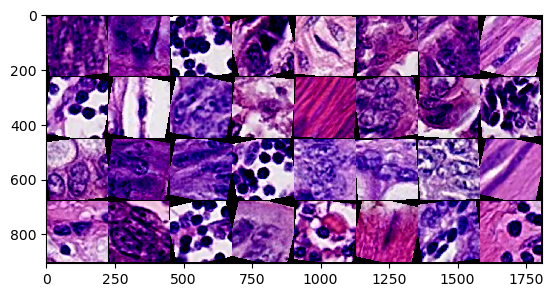

In [35]:
lr = 0.004

train_loader = DataLoader(train_data, batch_size=32)
val_loader = DataLoader(val_data, batch_size=32)
model = Net()
# we set the optimiser as Stochastic Gradient Descent for both networks, 
# you could also try Adam
optimizer = optim.SGD(model.parameters(), lr=lr)

#optimizer = optim.Adam(model.parameters(), lr=lr)
#optimizer_dense = optim.Adam(model_dense.parameters(), lr=lr)

# show the first batch of training data (you don't need to understand this code)
images, labels = next(iter(train_loader))
grid = torchvision.utils.make_grid(images)
plt.imshow(np.transpose(grid.numpy(), (1,2,0)), interpolation='nearest')

# set the loss function to optimise. Cross Entropy is usually the best for 
# classification
loss_fn = nn.CrossEntropyLoss()

In [39]:
import datetime
from sklearn.metrics import confusion_matrix
import seaborn as sns


def training_loop(n_epochs, optimizer, model, device, loss_fn, train_loader, val_loader):
    model = model.to(device)
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    for epoch in range(1, n_epochs + 1):
        # Training
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        for imgs, labels in train_loader:
            outputs = model(imgs.to(device))
            loss = loss_fn(outputs, labels.to(device))
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct_train += (predicted == labels.to(device)).sum().item()
            total_train += len(labels)
            
        train_accuracy = correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        # Validation
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                outputs = model(imgs.to(device))
                loss = loss_fn(outputs, labels.to(device))
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                correct_val += (predicted == labels.to(device)).sum().item()
                total_val += len(labels)
                
            val_accuracy = correct_val / total_val
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)
        
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}, Training Accuracy {}, Validation Loss {}, Validation Accuracy {}'.format(
                datetime.datetime.now(), epoch, float(train_loss), train_accuracy, float(val_loss), val_accuracy))
    
    # Plot the loss curve
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    # Plot the accuracy curve
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
    # Compute the confusion matrix for validation data
    all_val_labels = []
    all_val_preds = []
    with torch.no_grad():
        for imgs, labels in val_loader:
            outputs = model(imgs.to(device))
            _, predicted = torch.max(outputs.data, 1)
            all_val_labels += labels.tolist()
            all_val_preds += predicted.tolist()
    val_cm = confusion_matrix(all_val_labels, all_val_preds)
    
    # Plot the confusion matrix for validation data
    sns.heatmap(val_cm, annot=True, cmap='Blues', fmt='g')
    plt.title('Validation Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

2023-03-26 12:42:53.517029 Epoch 1, Training loss 33.01941765472293, Training Accuracy 0.935515873015873, Validation Loss 12.222474630922079, Validation Accuracy 0.9054232804232805
2023-03-26 12:47:15.940804 Epoch 10, Training loss 28.93656406737864, Training Accuracy 0.9399801587301587, Validation Loss 11.13128150999546, Validation Accuracy 0.9193121693121693
2023-03-26 12:52:06.168828 Epoch 20, Training loss 26.01799670048058, Training Accuracy 0.9477513227513228, Validation Loss 10.391571307554841, Validation Accuracy 0.9212962962962963
2023-03-26 12:57:35.858066 Epoch 30, Training loss 23.584092025645077, Training Accuracy 0.9556878306878307, Validation Loss 11.811931328848004, Validation Accuracy 0.9146825396825397


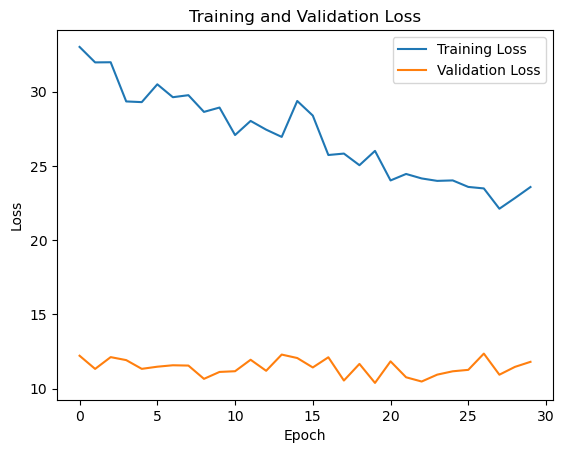

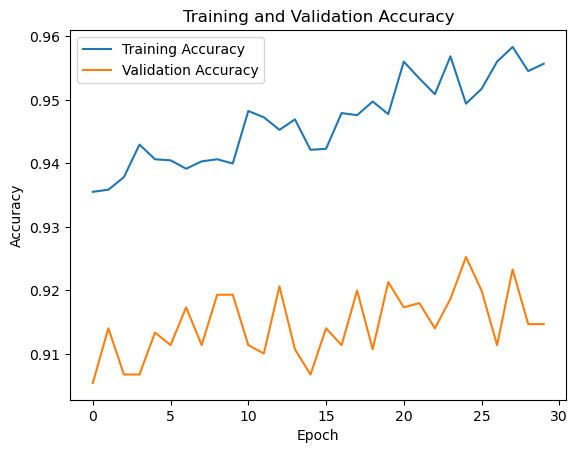

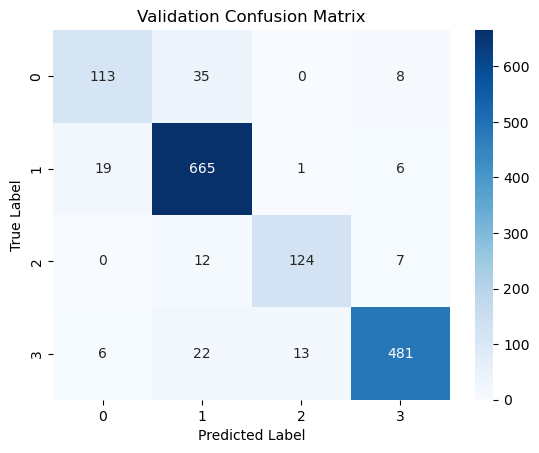

In [37]:
n_epochs = 30

training_loop(
    n_epochs = n_epochs, 
    optimizer = optimizer,
    model = model, 
    device = device,
    loss_fn = loss_fn,
    train_loader = train_loader,
    val_loader = val_loader
)

As evident from the curves, the model seems to be overfitting as the validation loss starts to increase while the training loss continues to decrease. Additionally, the validation accuracy shows a plateau while the training loss is increasing. 


Based on these training and validation metrics, it appears that the model is overfitting to the training data as the training loss continues to decrease while the validation loss starts to increase after a certain point. Additionally, the validation accuracy seems to be plateauing while the training accuracy continues to increase, which is another indication of overfitting. It may be worth exploring techniques such as regularization or adjusting the model architecture to address this overfitting issue.

The confusion matrix signifies that the model is able to predict Label 1 and Label 3 quite well and is fairly struggling to predict Label 0 and Label 2.

# **Captum**

Captum is a model interpretability library for PyTorch which will help to understand the model better.

In [36]:
!pip install captum

import torch
import torch.nn.functional as F

import urllib
from PIL import Image

import os
import json
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

import torchvision
from torchvision import models
from torchvision import transforms

from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz
from captum.attr import IntegratedGradients

Here, attribution analysis is performed on an image using the Integrated Gradients method. It visually represents the important regions of the image for the model's prediction.

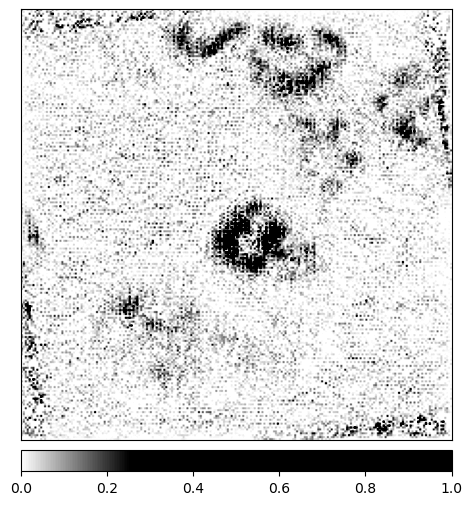

In [17]:
ig = IntegratedGradients(model)

model.eval()

image, label = next(iter(val_loader))

attributions, delta = ig.attribute(image.to(device), target=label.to(device), return_convergence_delta=True)

default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)
_ = viz.visualize_image_attr(np.transpose(attributions[0].squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(image[0].squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)

In [47]:
idx_to_labels = {
    '0': 'Normal epithelial cell nuclei',
    '1': 'Cancer epithelial cell nuclei',
    '2': 'Muscle cell nuclei',
    '3': 'Immune leukocyte cell nuclei'
}

Next, the first image in the validation data is predicted and the corresponding prediction score is retrived.

In [61]:
for i, data in enumerate(val_loader):
    inputs, labels = data
    if (i==1):
        break
output = model(inputs)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)

pred_label_idx.squeeze_()
predicted_label = idx_to_labels[str(pred_label_idx[0].item())]
print('Predicted:', predicted_label, '(', prediction_score.squeeze().tolist()[0], ')')

Predicted: Immune leukocyte cell nuclei ( 0.56986004114151 )


# **RESNET**

The pre-trained Model used is Resnet18 which is a Convolutional Neural Network with 18 layers. 

In [9]:
import torchvision.models as models

resnet_model = models.resnet18(pretrained=True)
resnet_model.eval()

in_features = resnet_model.fc.in_features
resnet_model.fc = torch.nn.Linear(in_features, 4)


/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [10]:
import datetime
epoch_print_gap = 1

def training_loop(n_epochs, optimizer, model, device, loss_fn, train_loader):
    model = model.to(device)
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            outputs = model(imgs.to(device))
            loss = loss_fn(outputs, labels.to(device))
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
            
        if epoch == 1 or epoch % epoch_print_gap == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch, float(loss_train)))

In [11]:
def val_loop(model, device, val_loader):
    model.eval()
    model = model.to(device)
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    val_loss /= len(val_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))

Here, the Optimizer used is Adam whereas the Loss Function remains the same (Cross Entropy Loss).

In [12]:
from torch.optim import Adam
loss_fn = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lr = 1e-4
resnet_optimized = Adam(resnet_model.parameters(), lr=lr, amsgrad=False)

In [54]:
n_epochs = 10

training_loop(
    n_epochs = n_epochs, 
    optimizer = resnet_optimized,
    model = resnet_model, 
    device = device,
    loss_fn = loss_fn,
    train_loader = train_loader
)

2023-03-27 06:06:11.457564 Epoch 1, Training loss 100.54270008206367
2023-03-27 06:06:49.448642 Epoch 2, Training loss 64.09434581920505
2023-03-27 06:07:29.529100 Epoch 3, Training loss 48.78103209659457
2023-03-27 06:08:08.126194 Epoch 4, Training loss 42.023906748741865
2023-03-27 06:08:46.371827 Epoch 5, Training loss 36.64530354272574
2023-03-27 06:09:24.708738 Epoch 6, Training loss 30.63196259457618
2023-03-27 06:10:02.921278 Epoch 7, Training loss 25.45468267519027
2023-03-27 06:10:41.647993 Epoch 8, Training loss 19.5887277580332
2023-03-27 06:11:20.213044 Epoch 9, Training loss 19.320058183162473
2023-03-27 06:11:58.378200 Epoch 10, Training loss 19.17929352633655


In [55]:
val_loop(model = resnet_model, device = device, val_loader = val_loader)


Test set: Average loss: 0.1361, Accuracy: 1441/1512 (95%)



In [56]:
resnet_model = resnet_model.to("cpu")
accuracy, df = test_accuracy(resnet_model, test_data, device="cpu")

In [57]:
df

,Filename,Label
0,10001.png,3
1,10002.png,3
2,10003.png,2
3,10004.png,3
4,10005.png,3
...,...,...
5036,15037.png,1
5037,15038.png,1
5038,15039.png,0
5039,15040.png,2


In [58]:
os.chdir('/kaggle/working/')

In [60]:
df.to_csv('submission.csv', index=False)

# **RESNET TUNING**

Ray Tuning is again used to tune the hyperparameters and get the best possible configuration.

In [144]:
def train_loop_raytuning(config, checkpoint_dir=None, data_dir=None):
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        #if torch.cuda.device_count() > 1:
            #net = nn.DataParallel(net)
    restnet_model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(restnet_model.parameters(), lr=config["lr"], momentum=0.9)

    if checkpoint_dir:
        model_state, optimizer_state = torch.load(
            os.path.join(checkpoint_dir, "checkpoint"))
        net.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)



    trainloader = torch.utils.data.DataLoader(
        train_data,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=8)
    valloader = torch.utils.data.DataLoader(
        val_data,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=8)

    for epoch in range(10):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_steps = 0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = restnet_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            epoch_steps += 1
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1,
                                                running_loss / epoch_steps))
                running_loss = 0.0

        # Validation loss
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        for i, data in enumerate(valloader, 0):
            with torch.no_grad():
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = restnet_model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                loss = criterion(outputs, labels)
                val_loss += loss.cpu().numpy()
                val_steps += 1

        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((restnet_model.state_dict(), optimizer.state_dict()), path)

        tune.report(loss=(val_loss / val_steps), accuracy=correct / total)
    print("Finished Training")

In [145]:
def main(num_samples=10, max_num_epochs=10, gpus_per_trial=2):


    config = {
        #"l1": tune.sample_from(lambda _: 2 ** np.random.randint(2, 9)),
        #"l2": tune.sample_from(lambda _: 2 ** np.random.randint(2, 9)),
        "lr": tune.loguniform(1e-4, 1e-1),
        "batch_size": tune.choice([2, 4, 8, 16])
    }
    scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=max_num_epochs,
        grace_period=1,
        reduction_factor=2)
    reporter = CLIReporter(
        # parameter_columns=["l1", "l2", "lr", "batch_size"],
        metric_columns=["loss", "accuracy", "training_iteration"])
    result = tune.run(
        partial(train_loop_raytuning),
        chdir_to_trial_dir=False,
        resources_per_trial={"cpu": 2, "gpu": gpus_per_trial},
        config=config,
        num_samples=num_samples,
        scheduler=scheduler,
        progress_reporter=reporter)

    best_trial = result.get_best_trial("loss", "min", "last")
    print("Best trial config: {}".format(best_trial.config))
    print("Best trial final validation loss: {}".format(
        best_trial.last_result["loss"]))
    print("Best trial final validation accuracy: {}".format(
        best_trial.last_result["accuracy"]))

    best_trained_model = restnet_model
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if gpus_per_trial > 1:
            best_trained_model = nn.DataParallel(best_trained_model)
    best_trained_model.to(device)

    best_checkpoint_dir = best_trial.checkpoint.dir_or_data
    model_state, optimizer_state = torch.load(os.path.join(
        best_checkpoint_dir, "checkpoint"))
    
    test_acc = test_accuracy(best_trained_model, test_data, device)
    
    return best_trained_model

In [58]:
best = main(num_samples=5, max_num_epochs=5, gpus_per_trial=2)

2023-03-26 01:27:44,188	WARNING worker.py:1851 -- Warning: The actor ImplicitFunc is very large (42 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.
2023-03-26 01:27:44,400	WARNING util.py:244 -- The `start_trial` operation took 1.736 s, which may be a performance bottleneck.


== Status ==
Current time: 2023-03-26 01:27:44 (running for 00:00:05.98)
Memory usage on this node: 6.4/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.11 GiB heap, 0.0/3.55 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_loop_raytuning_2023-03-26_01-27-38
Number of trials: 5/5 (4 PENDING, 1 RUNNING)
+----------------------------------+----------+------------------+--------------+-------------+
| Trial name                       | status   | loc              |   batch_size |          lr |
|----------------------------------+----------+------------------+--------------+-------------|
| train_loop_raytuning_64fd3_00000 | RUNNING  | 172.19.2.2:20845 |            4 | 0.000456238 |
| train_loop_raytuning_64fd3_00001 | PENDING  |                  |           16 | 0.00432727  |
| train_loop_raytuning_64fd3_00002 | PENDING  |                  |      

(func pid=20845) /opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=20845)   cpuset_checked))
(func pid=20845) E0326 01:27:52.112250192   20888 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=20845) E0326 01:27:52.178582264   20888 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 01:27:57 (running for 00:00:18.68)
Memory usage on this node: 9.2/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.11 GiB heap, 0.0/3.55 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_loop_raytuning_2023-03-26_01-27-38
Number of trials: 5/5 (4 PENDING, 1 RUNNING)
+----------------------------------+----------+------------------+--------------+-------------+
| Trial name                       | status   | loc              |   batch_size |          lr |
|----------------------------------+----------+------------------+--------------+-------------|
| train_loop_raytuning_64fd3_00000 | RUNNING  | 172.19.2.2:20845 |            4 | 0.000456238 |
| train_loop_raytuning_64fd3_00001 | PENDING  |                  |           16 | 0.00432727  |
| train_loop_raytuning_64fd3_00002 | PENDING  |                  |      

(func pid=20845) E0326 01:28:41.352392108   20888 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=20845) E0326 01:28:41.601402702   20888 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 01:28:42 (running for 00:01:03.75)
Memory usage on this node: 9.3/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.11 GiB heap, 0.0/3.55 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_loop_raytuning_2023-03-26_01-27-38
Number of trials: 5/5 (4 PENDING, 1 RUNNING)
+----------------------------------+----------+------------------+--------------+-------------+
| Trial name                       | status   | loc              |   batch_size |          lr |
|----------------------------------+----------+------------------+--------------+-------------|
| train_loop_raytuning_64fd3_00000 | RUNNING  | 172.19.2.2:20845 |            4 | 0.000456238 |
| train_loop_raytuning_64fd3_00001 | PENDING  |                  |           16 | 0.00432727  |
| train_loop_raytuning_64fd3_00002 | PENDING  |                  |      

Trial name,accuracy,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,loss,node_ip,pid,should_checkpoint,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
train_loop_raytuning_64fd3_00000,0.904101,2023-03-26_01-32-27,True,,f247ce6d04d94a3b9c59caed144c0e82,d6e2319a7a84,5,0.241555,172.19.2.2,20845,True,275.236,54.3895,275.236,1679794347,0,,5,64fd3_00000,0.00556564
train_loop_raytuning_64fd3_00001,0.103175,2023-03-26_01-35-37,True,,dd375284947345a3adc510570e8d79e9,d6e2319a7a84,5,nan,172.19.2.2,21967,True,181.687,36.1788,181.687,1679794537,0,,5,64fd3_00001,0.00653291
train_loop_raytuning_64fd3_00002,0.103175,2023-03-26_01-39-16,True,,830e88b68dcb46bb975275722ebeabba,d6e2319a7a84,5,nan,172.19.2.2,23056,True,210.793,40.7432,210.793,1679794756,0,,5,64fd3_00002,0.00477266
train_loop_raytuning_64fd3_00003,0.974868,2023-03-26_01-42-30,True,,a14813209bb044ee8c0b21e38d027f02,d6e2319a7a84,5,0.0781641,172.19.2.2,24156,True,185.207,38.9255,185.207,1679794950,0,,5,64fd3_00003,0.00490689
train_loop_raytuning_64fd3_00004,0.103175,2023-03-26_01-45-36,True,,ce652f54c5a84025996dbf6c64120282,d6e2319a7a84,5,nan,172.19.2.2,25273,True,178.012,35.6005,178.012,1679795136,0,,5,64fd3_00004,0.00794387


(func pid=20845) E0326 01:28:49.430408123   20888 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=20845) E0326 01:28:49.598959836   20888 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 01:28:54 (running for 00:01:16.00)
Memory usage on this node: 9.3/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 4.000: None | Iter 2.000: None | Iter 1.000: -0.3302869794081999
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.11 GiB heap, 0.0/3.55 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_loop_raytuning_2023-03-26_01-27-38
Number of trials: 5/5 (4 PENDING, 1 RUNNING)
+----------------------------------+----------+------------------+--------------+-------------+----------+------------+----------------------+
| Trial name                       | status   | loc              |   batch_size |          lr |     loss |   accuracy |   training_iteration |
|----------------------------------+----------+------------------+--------------+-------------+----------+------------+----------------------|
| train_loop_raytuning_64fd3_00000 | RUNNING  | 172.19.2.2:20845 |            4 | 0.000456238 | 0.330287 |  

(func pid=20845) E0326 01:29:44.346621594   20888 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=20845) E0326 01:29:44.483243464   20888 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 01:29:49 (running for 00:02:10.78)
Memory usage on this node: 9.3/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 4.000: None | Iter 2.000: -0.12189890431786879 | Iter 1.000: -0.3302869794081999
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.11 GiB heap, 0.0/3.55 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_loop_raytuning_2023-03-26_01-27-38
Number of trials: 5/5 (4 PENDING, 1 RUNNING)
+----------------------------------+----------+------------------+--------------+-------------+----------+------------+----------------------+
| Trial name                       | status   | loc              |   batch_size |          lr |     loss |   accuracy |   training_iteration |
|----------------------------------+----------+------------------+--------------+-------------+----------+------------+----------------------|
| train_loop_raytuning_64fd3_00000 | RUNNING  | 172.19.2.2:20845 |            4 | 0.00045623

(func pid=20845) E0326 01:30:30.691140469   20888 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 01:30:34 (running for 00:02:55.86)
Memory usage on this node: 9.2/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 4.000: None | Iter 2.000: -0.12189890431786879 | Iter 1.000: -0.3302869794081999
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.11 GiB heap, 0.0/3.55 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_loop_raytuning_2023-03-26_01-27-38
Number of trials: 5/5 (4 PENDING, 1 RUNNING)
+----------------------------------+----------+------------------+--------------+-------------+----------+------------+----------------------+
| Trial name                       | status   | loc              |   batch_size |          lr |     loss |   accuracy |   training_iteration |
|----------------------------------+----------+------------------+--------------+-------------+----------+------------+----------------------|
| train_loop_raytuning_64fd3_00000 | RUNNING  | 172.19.2.2:20845 |            4 | 0.00045623

(func pid=20845) E0326 01:30:38.944505221   20888 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 01:30:43 (running for 00:03:05.26)
Memory usage on this node: 9.2/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 4.000: None | Iter 2.000: -0.12189890431786879 | Iter 1.000: -0.3302869794081999
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.11 GiB heap, 0.0/3.55 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_loop_raytuning_2023-03-26_01-27-38
Number of trials: 5/5 (4 PENDING, 1 RUNNING)
+----------------------------------+----------+------------------+--------------+-------------+----------+------------+----------------------+
| Trial name                       | status   | loc              |   batch_size |          lr |     loss |   accuracy |   training_iteration |
|----------------------------------+----------+------------------+--------------+-------------+----------+------------+----------------------|
| train_loop_raytuning_64fd3_00000 | RUNNING  | 172.19.2.2:20845 |            4 | 0.00045623

(func pid=20845) E0326 01:31:25.110061173   20888 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=20845) E0326 01:31:25.157135071   20888 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=20845) E0326 01:31:25.274965641   20888 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 01:31:28 (running for 00:03:50.35)
Memory usage on this node: 9.3/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 4.000: None | Iter 2.000: -0.12189890431786879 | Iter 1.000: -0.3302869794081999
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.11 GiB heap, 0.0/3.55 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_loop_raytuning_2023-03-26_01-27-38
Number of trials: 5/5 (4 PENDING, 1 RUNNING)
+----------------------------------+----------+------------------+--------------+-------------+----------+------------+----------------------+
| Trial name                       | status   | loc              |   batch_size |          lr |     loss |   accuracy |   training_iteration |
|----------------------------------+----------+------------------+--------------+-------------+----------+------------+----------------------|
| train_loop_raytuning_64fd3_00000 | RUNNING  | 172.19.2.2:20845 |            4 | 0.00045623

(func pid=20845) E0326 01:31:32.968036150   20888 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=20845) E0326 01:31:33.139325804   20888 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=20845) E0326 01:31:33.265832339   20888 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 01:31:37 (running for 00:03:59.54)
Memory usage on this node: 9.3/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 4.000: -0.2670889149800931 | Iter 2.000: -0.12189890431786879 | Iter 1.000: -0.3302869794081999
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.11 GiB heap, 0.0/3.55 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_loop_raytuning_2023-03-26_01-27-38
Number of trials: 5/5 (4 PENDING, 1 RUNNING)
+----------------------------------+----------+------------------+--------------+-------------+----------+------------+----------------------+
| Trial name                       | status   | loc              |   batch_size |          lr |     loss |   accuracy |   training_iteration |
|----------------------------------+----------+------------------+--------------+-------------+----------+------------+----------------------|
| train_loop_raytuning_64fd3_00000 | RUNNING  | 172.19.2.2:20845 |           

2023-03-26 01:32:28,944	WARNING util.py:244 -- The `start_trial` operation took 0.597 s, which may be a performance bottleneck.


== Status ==
Current time: 2023-03-26 01:32:28 (running for 00:04:50.52)
Memory usage on this node: 6.4/15.6 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 4.000: -0.2670889149800931 | Iter 2.000: -0.12189890431786879 | Iter 1.000: -0.3302869794081999
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.11 GiB heap, 0.0/3.55 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_loop_raytuning_2023-03-26_01-27-38
Number of trials: 5/5 (3 PENDING, 1 RUNNING, 1 TERMINATED)
+----------------------------------+------------+------------------+--------------+-------------+----------+------------+----------------------+
| Trial name                       | status     | loc              |   batch_size |          lr |     loss |   accuracy |   training_iteration |
|----------------------------------+------------+------------------+--------------+-------------+----------+------------+----------------------|
| train_loop_raytuning_64fd3_00001 | RUNNING    | 172.19.

(func pid=21967) /opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=21967)   cpuset_checked))
(func pid=21967) E0326 01:32:35.800920516   22003 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 01:32:40 (running for 00:05:02.38)
Memory usage on this node: 9.4/15.6 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 4.000: -0.2670889149800931 | Iter 2.000: -0.12189890431786879 | Iter 1.000: -0.3302869794081999
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.11 GiB heap, 0.0/3.55 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_loop_raytuning_2023-03-26_01-27-38
Number of trials: 5/5 (3 PENDING, 1 RUNNING, 1 TERMINATED)
+----------------------------------+------------+------------------+--------------+-------------+----------+------------+----------------------+
| Trial name                       | status     | loc              |   batch_size |          lr |     loss |   accuracy |   training_iteration |
|----------------------------------+------------+------------------+--------------+-------------+----------+------------+----------------------|
| train_loop_raytuning_64fd3_00001 | RUNNING    | 172.19.

(func pid=21967) E0326 01:33:06.544906244   22003 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 01:33:10 (running for 00:05:32.46)
Memory usage on this node: 9.3/15.6 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 4.000: -0.2670889149800931 | Iter 2.000: -0.12189890431786879 | Iter 1.000: -0.3302869794081999
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.11 GiB heap, 0.0/3.55 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_loop_raytuning_2023-03-26_01-27-38
Number of trials: 5/5 (3 PENDING, 1 RUNNING, 1 TERMINATED)
+----------------------------------+------------+------------------+--------------+-------------+----------+------------+----------------------+
| Trial name                       | status     | loc              |   batch_size |          lr |     loss |   accuracy |   training_iteration |
|----------------------------------+------------+------------------+--------------+-------------+----------+------------+----------------------|
| train_loop_raytuning_64fd3_00001 | RUNNING    | 172.19.

(func pid=21967) E0326 01:33:12.459543270   22003 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=21967) E0326 01:33:12.779894965   22003 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 01:33:17 (running for 00:05:39.04)
Memory usage on this node: 9.3/15.6 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 4.000: -0.2670889149800931 | Iter 2.000: -0.12189890431786879 | Iter 1.000: -0.3302869794081999
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.11 GiB heap, 0.0/3.55 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_loop_raytuning_2023-03-26_01-27-38
Number of trials: 5/5 (3 PENDING, 1 RUNNING, 1 TERMINATED)
+----------------------------------+------------+------------------+--------------+-------------+------------+------------+----------------------+
| Trial name                       | status     | loc              |   batch_size |          lr |       loss |   accuracy |   training_iteration |
|----------------------------------+------------+------------------+--------------+-------------+------------+------------+----------------------|
| train_loop_raytuning_64fd3_00001 | RUNNING    | 1

(func pid=21967) E0326 01:33:42.262910251   22003 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 01:33:42 (running for 00:06:04.11)
Memory usage on this node: 9.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 4.000: -0.2670889149800931 | Iter 2.000: -0.12189890431786879 | Iter 1.000: -0.3302869794081999
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.11 GiB heap, 0.0/3.55 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_loop_raytuning_2023-03-26_01-27-38
Number of trials: 5/5 (3 PENDING, 1 RUNNING, 1 TERMINATED)
+----------------------------------+------------+------------------+--------------+-------------+------------+------------+----------------------+
| Trial name                       | status     | loc              |   batch_size |          lr |       loss |   accuracy |   training_iteration |
|----------------------------------+------------+------------------+--------------+-------------+------------+------------+----------------------|
| train_loop_raytuning_64fd3_00001 | RUNNING    | 1

(func pid=21967) E0326 01:33:48.949233584   22003 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=21967) E0326 01:33:49.176557140   22003 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 01:33:53 (running for 00:06:15.40)
Memory usage on this node: 9.4/15.6 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 4.000: -0.2670889149800931 | Iter 2.000: -0.12189890431786879 | Iter 1.000: -0.3302869794081999
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.11 GiB heap, 0.0/3.55 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_loop_raytuning_2023-03-26_01-27-38
Number of trials: 5/5 (3 PENDING, 1 RUNNING, 1 TERMINATED)
+----------------------------------+------------+------------------+--------------+-------------+------------+------------+----------------------+
| Trial name                       | status     | loc              |   batch_size |          lr |       loss |   accuracy |   training_iteration |
|----------------------------------+------------+------------------+--------------+-------------+------------+------------+----------------------|
| train_loop_raytuning_64fd3_00001 | RUNNING    | 1

(func pid=21967) E0326 01:34:25.587811831   22003 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 01:34:30 (running for 00:06:52.12)
Memory usage on this node: 9.4/15.6 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 4.000: -0.2670889149800931 | Iter 2.000: -0.12189890431786879 | Iter 1.000: -0.3302869794081999
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.11 GiB heap, 0.0/3.55 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_loop_raytuning_2023-03-26_01-27-38
Number of trials: 5/5 (3 PENDING, 1 RUNNING, 1 TERMINATED)
+----------------------------------+------------+------------------+--------------+-------------+------------+------------+----------------------+
| Trial name                       | status     | loc              |   batch_size |          lr |       loss |   accuracy |   training_iteration |
|----------------------------------+------------+------------------+--------------+-------------+------------+------------+----------------------|
| train_loop_raytuning_64fd3_00001 | RUNNING    | 1

(func pid=21967) E0326 01:34:54.926856484   22003 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 01:34:55 (running for 00:07:17.17)
Memory usage on this node: 9.2/15.6 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 4.000: -0.2670889149800931 | Iter 2.000: -0.12189890431786879 | Iter 1.000: -0.3302869794081999
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.11 GiB heap, 0.0/3.55 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_loop_raytuning_2023-03-26_01-27-38
Number of trials: 5/5 (3 PENDING, 1 RUNNING, 1 TERMINATED)
+----------------------------------+------------+------------------+--------------+-------------+------------+------------+----------------------+
| Trial name                       | status     | loc              |   batch_size |          lr |       loss |   accuracy |   training_iteration |
|----------------------------------+------------+------------------+--------------+-------------+------------+------------+----------------------|
| train_loop_raytuning_64fd3_00001 | RUNNING    | 1

(func pid=21967) E0326 01:35:01.530242963   22003 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 01:35:06 (running for 00:07:27.90)
Memory usage on this node: 9.4/15.6 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 4.000: -0.2670889149800931 | Iter 2.000: -0.12189890431786879 | Iter 1.000: -0.3302869794081999
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.11 GiB heap, 0.0/3.55 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_loop_raytuning_2023-03-26_01-27-38
Number of trials: 5/5 (3 PENDING, 1 RUNNING, 1 TERMINATED)
+----------------------------------+------------+------------------+--------------+-------------+------------+------------+----------------------+
| Trial name                       | status     | loc              |   batch_size |          lr |       loss |   accuracy |   training_iteration |
|----------------------------------+------------+------------------+--------------+-------------+------------+------------+----------------------|
| train_loop_raytuning_64fd3_00001 | RUNNING    | 1

2023-03-26 01:35:38,952	WARNING util.py:244 -- The `start_trial` operation took 0.570 s, which may be a performance bottleneck.


== Status ==
Current time: 2023-03-26 01:35:43 (running for 00:08:05.53)
Memory usage on this node: 6.7/15.6 GiB 
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 4.000: -0.2670889149800931 | Iter 2.000: -0.12189890431786879 | Iter 1.000: -0.3302869794081999
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.11 GiB heap, 0.0/3.55 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_loop_raytuning_2023-03-26_01-27-38
Number of trials: 5/5 (2 PENDING, 1 RUNNING, 2 TERMINATED)
+----------------------------------+------------+------------------+--------------+-------------+------------+------------+----------------------+
| Trial name                       | status     | loc              |   batch_size |          lr |       loss |   accuracy |   training_iteration |
|----------------------------------+------------+------------------+--------------+-------------+------------+------------+----------------------|
| train_loop_raytuning_64fd3_00002 | RUNNING    | 1

(func pid=23056) /opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=23056)   cpuset_checked))
(func pid=23056) E0326 01:35:46.068229679   23098 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 01:35:51 (running for 00:08:12.65)
Memory usage on this node: 9.3/15.6 GiB 
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 4.000: -0.2670889149800931 | Iter 2.000: -0.12189890431786879 | Iter 1.000: -0.3302869794081999
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.11 GiB heap, 0.0/3.55 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_loop_raytuning_2023-03-26_01-27-38
Number of trials: 5/5 (2 PENDING, 1 RUNNING, 2 TERMINATED)
+----------------------------------+------------+------------------+--------------+-------------+------------+------------+----------------------+
| Trial name                       | status     | loc              |   batch_size |          lr |       loss |   accuracy |   training_iteration |
|----------------------------------+------------+------------------+--------------+-------------+------------+------------+----------------------|
| train_loop_raytuning_64fd3_00002 | RUNNING    | 1

(func pid=23056) E0326 01:36:23.900103670   23098 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 01:36:26 (running for 00:08:47.72)
Memory usage on this node: 9.3/15.6 GiB 
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 4.000: -0.2670889149800931 | Iter 2.000: -0.12189890431786879 | Iter 1.000: -0.3302869794081999
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.11 GiB heap, 0.0/3.55 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_loop_raytuning_2023-03-26_01-27-38
Number of trials: 5/5 (2 PENDING, 1 RUNNING, 2 TERMINATED)
+----------------------------------+------------+------------------+--------------+-------------+------------+------------+----------------------+
| Trial name                       | status     | loc              |   batch_size |          lr |       loss |   accuracy |   training_iteration |
|----------------------------------+------------+------------------+--------------+-------------+------------+------------+----------------------|
| train_loop_raytuning_64fd3_00002 | RUNNING    | 1

(func pid=23056) E0326 01:36:31.279480050   23098 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=23056) E0326 01:36:31.329428099   23098 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 01:36:36 (running for 00:08:57.65)
Memory usage on this node: 9.3/15.6 GiB 
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 4.000: -0.2670889149800931 | Iter 2.000: -0.12189890431786879 | Iter 1.000: -0.3302869794081999
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.11 GiB heap, 0.0/3.55 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_loop_raytuning_2023-03-26_01-27-38
Number of trials: 5/5 (2 PENDING, 1 RUNNING, 2 TERMINATED)
+----------------------------------+------------+------------------+--------------+-------------+------------+------------+----------------------+
| Trial name                       | status     | loc              |   batch_size |          lr |       loss |   accuracy |   training_iteration |
|----------------------------------+------------+------------------+--------------+-------------+------------+------------+----------------------|
| train_loop_raytuning_64fd3_00002 | RUNNING    | 1

(func pid=23056) E0326 01:37:06.156785246   23098 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=23056) E0326 01:37:06.245827422   23098 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=23056) E0326 01:37:06.285891005   23098 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 01:37:11 (running for 00:09:32.71)
Memory usage on this node: 9.3/15.6 GiB 
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 4.000: -0.2670889149800931 | Iter 2.000: -0.12189890431786879 | Iter 1.000: -0.3302869794081999
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.11 GiB heap, 0.0/3.55 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_loop_raytuning_2023-03-26_01-27-38
Number of trials: 5/5 (2 PENDING, 1 RUNNING, 2 TERMINATED)
+----------------------------------+------------+------------------+--------------+-------------+------------+------------+----------------------+
| Trial name                       | status     | loc              |   batch_size |          lr |       loss |   accuracy |   training_iteration |
|----------------------------------+------------+------------------+--------------+-------------+------------+------------+----------------------|
| train_loop_raytuning_64fd3_00002 | RUNNING    | 1

(func pid=23056) E0326 01:37:12.712861794   23098 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 01:37:17 (running for 00:09:39.16)
Memory usage on this node: 9.3/15.6 GiB 
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 4.000: -0.2670889149800931 | Iter 2.000: -0.12189890431786879 | Iter 1.000: -0.3302869794081999
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.11 GiB heap, 0.0/3.55 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_loop_raytuning_2023-03-26_01-27-38
Number of trials: 5/5 (2 PENDING, 1 RUNNING, 2 TERMINATED)
+----------------------------------+------------+------------------+--------------+-------------+------------+------------+----------------------+
| Trial name                       | status     | loc              |   batch_size |          lr |       loss |   accuracy |   training_iteration |
|----------------------------------+------------+------------------+--------------+-------------+------------+------------+----------------------|
| train_loop_raytuning_64fd3_00002 | RUNNING    | 1

(func pid=23056) E0326 01:37:47.234900417   23098 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=23056) E0326 01:37:47.524243761   23098 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 01:37:47 (running for 00:10:09.21)
Memory usage on this node: 9.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 4.000: -0.2670889149800931 | Iter 2.000: -0.12189890431786879 | Iter 1.000: -0.3302869794081999
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.11 GiB heap, 0.0/3.55 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_loop_raytuning_2023-03-26_01-27-38
Number of trials: 5/5 (2 PENDING, 1 RUNNING, 2 TERMINATED)
+----------------------------------+------------+------------------+--------------+-------------+------------+------------+----------------------+
| Trial name                       | status     | loc              |   batch_size |          lr |       loss |   accuracy |   training_iteration |
|----------------------------------+------------+------------------+--------------+-------------+------------+------------+----------------------|
| train_loop_raytuning_64fd3_00002 | RUNNING    | 1

(func pid=23056) E0326 01:37:54.304826532   23098 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=23056) E0326 01:37:54.347480821   23098 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 01:37:59 (running for 00:10:20.67)
Memory usage on this node: 9.3/15.6 GiB 
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 4.000: -0.2670889149800931 | Iter 2.000: -0.12189890431786879 | Iter 1.000: -0.3302869794081999
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.11 GiB heap, 0.0/3.55 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_loop_raytuning_2023-03-26_01-27-38
Number of trials: 5/5 (2 PENDING, 1 RUNNING, 2 TERMINATED)
+----------------------------------+------------+------------------+--------------+-------------+------------+------------+----------------------+
| Trial name                       | status     | loc              |   batch_size |          lr |       loss |   accuracy |   training_iteration |
|----------------------------------+------------+------------------+--------------+-------------+------------+------------+----------------------|
| train_loop_raytuning_64fd3_00002 | RUNNING    | 1

(func pid=23056) E0326 01:38:28.925934520   23098 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 01:38:29 (running for 00:10:50.73)
Memory usage on this node: 9.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 4.000: -0.2670889149800931 | Iter 2.000: -0.12189890431786879 | Iter 1.000: -0.3302869794081999
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.11 GiB heap, 0.0/3.55 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_loop_raytuning_2023-03-26_01-27-38
Number of trials: 5/5 (2 PENDING, 1 RUNNING, 2 TERMINATED)
+----------------------------------+------------+------------------+--------------+-------------+------------+------------+----------------------+
| Trial name                       | status     | loc              |   batch_size |          lr |       loss |   accuracy |   training_iteration |
|----------------------------------+------------+------------------+--------------+-------------+------------+------------+----------------------|
| train_loop_raytuning_64fd3_00002 | RUNNING    | 1

2023-03-26 01:39:18,007	WARNING util.py:244 -- The `start_trial` operation took 0.595 s, which may be a performance bottleneck.


== Status ==
Current time: 2023-03-26 01:39:23 (running for 00:11:44.59)
Memory usage on this node: 6.7/15.6 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 4.000: -0.2670889149800931 | Iter 2.000: -0.12189890431786879 | Iter 1.000: -0.3302869794081999
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.11 GiB heap, 0.0/3.55 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_loop_raytuning_2023-03-26_01-27-38
Number of trials: 5/5 (1 PENDING, 1 RUNNING, 3 TERMINATED)
+----------------------------------+------------+------------------+--------------+-------------+------------+------------+----------------------+
| Trial name                       | status     | loc              |   batch_size |          lr |       loss |   accuracy |   training_iteration |
|----------------------------------+------------+------------------+--------------+-------------+------------+------------+----------------------|
| train_loop_raytuning_64fd3_00003 | RUNNING    | 1

(func pid=24156) /opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=24156)   cpuset_checked))
(func pid=24156) E0326 01:39:25.075685678   24199 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=24156) E0326 01:39:25.103460560   24199 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 01:39:30 (running for 00:11:51.64)
Memory usage on this node: 9.4/15.6 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 4.000: -0.2670889149800931 | Iter 2.000: -0.12189890431786879 | Iter 1.000: -0.3302869794081999
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.11 GiB heap, 0.0/3.55 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_loop_raytuning_2023-03-26_01-27-38
Number of trials: 5/5 (1 PENDING, 1 RUNNING, 3 TERMINATED)
+----------------------------------+------------+------------------+--------------+-------------+------------+------------+----------------------+
| Trial name                       | status     | loc              |   batch_size |          lr |       loss |   accuracy |   training_iteration |
|----------------------------------+------------+------------------+--------------+-------------+------------+------------+----------------------|
| train_loop_raytuning_64fd3_00003 | RUNNING    | 1

(func pid=24156) E0326 01:39:56.601104509   24199 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 01:40:00 (running for 00:12:21.70)
Memory usage on this node: 9.4/15.6 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 4.000: -0.2670889149800931 | Iter 2.000: -0.12189890431786879 | Iter 1.000: -0.3302869794081999
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.11 GiB heap, 0.0/3.55 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_loop_raytuning_2023-03-26_01-27-38
Number of trials: 5/5 (1 PENDING, 1 RUNNING, 3 TERMINATED)
+----------------------------------+------------+------------------+--------------+-------------+------------+------------+----------------------+
| Trial name                       | status     | loc              |   batch_size |          lr |       loss |   accuracy |   training_iteration |
|----------------------------------+------------+------------------+--------------+-------------+------------+------------+----------------------|
| train_loop_raytuning_64fd3_00003 | RUNNING    | 1

(func pid=24156) E0326 01:40:02.533412594   24199 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 01:40:07 (running for 00:12:28.91)
Memory usage on this node: 9.5/15.6 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 4.000: -0.2670889149800931 | Iter 2.000: -0.12189890431786879 | Iter 1.000: -0.21065908466685757
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.11 GiB heap, 0.0/3.55 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_loop_raytuning_2023-03-26_01-27-38
Number of trials: 5/5 (1 PENDING, 1 RUNNING, 3 TERMINATED)
+----------------------------------+------------+------------------+--------------+-------------+-------------+------------+----------------------+
| Trial name                       | status     | loc              |   batch_size |          lr |        loss |   accuracy |   training_iteration |
|----------------------------------+------------+------------------+--------------+-------------+-------------+------------+----------------------|
| train_loop_raytuning_64fd3_00003 | RUNNING   

(func pid=24156) E0326 01:40:32.775117310   24199 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=24156) E0326 01:40:32.820802870   24199 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=24156) E0326 01:40:32.872093190   24199 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 01:40:37 (running for 00:12:58.99)
Memory usage on this node: 9.5/15.6 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 4.000: -0.2670889149800931 | Iter 2.000: -0.12189890431786879 | Iter 1.000: -0.21065908466685757
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.11 GiB heap, 0.0/3.55 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_loop_raytuning_2023-03-26_01-27-38
Number of trials: 5/5 (1 PENDING, 1 RUNNING, 3 TERMINATED)
+----------------------------------+------------+------------------+--------------+-------------+-------------+------------+----------------------+
| Trial name                       | status     | loc              |   batch_size |          lr |        loss |   accuracy |   training_iteration |
|----------------------------------+------------+------------------+--------------+-------------+-------------+------------+----------------------|
| train_loop_raytuning_64fd3_00003 | RUNNING   

(func pid=24156) E0326 01:41:08.723256348   24199 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 01:41:09 (running for 00:13:31.33)
Memory usage on this node: 9.4/15.6 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 4.000: -0.2670889149800931 | Iter 2.000: -0.1016424822168398 | Iter 1.000: -0.21065908466685757
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.11 GiB heap, 0.0/3.55 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_loop_raytuning_2023-03-26_01-27-38
Number of trials: 5/5 (1 PENDING, 1 RUNNING, 3 TERMINATED)
+----------------------------------+------------+------------------+--------------+-------------+-------------+------------+----------------------+
| Trial name                       | status     | loc              |   batch_size |          lr |        loss |   accuracy |   training_iteration |
|----------------------------------+------------+------------------+--------------+-------------+-------------+------------+----------------------|
| train_loop_raytuning_64fd3_00003 | RUNNING    

(func pid=24156) E0326 01:41:45.359883007   24199 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 01:41:45 (running for 00:14:07.19)
Memory usage on this node: 9.2/15.6 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 4.000: -0.2670889149800931 | Iter 2.000: -0.1016424822168398 | Iter 1.000: -0.21065908466685757
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.11 GiB heap, 0.0/3.55 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_loop_raytuning_2023-03-26_01-27-38
Number of trials: 5/5 (1 PENDING, 1 RUNNING, 3 TERMINATED)
+----------------------------------+------------+------------------+--------------+-------------+-------------+------------+----------------------+
| Trial name                       | status     | loc              |   batch_size |          lr |        loss |   accuracy |   training_iteration |
|----------------------------------+------------+------------------+--------------+-------------+-------------+------------+----------------------|
| train_loop_raytuning_64fd3_00003 | RUNNING    

(func pid=24156) E0326 01:42:24.013259537   24199 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 01:42:26 (running for 00:14:48.01)
Memory usage on this node: 9.4/15.6 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 4.000: -0.17628872175985943 | Iter 2.000: -0.1016424822168398 | Iter 1.000: -0.21065908466685757
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.11 GiB heap, 0.0/3.55 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_loop_raytuning_2023-03-26_01-27-38
Number of trials: 5/5 (1 PENDING, 1 RUNNING, 3 TERMINATED)
+----------------------------------+------------+------------------+--------------+-------------+-------------+------------+----------------------+
| Trial name                       | status     | loc              |   batch_size |          lr |        loss |   accuracy |   training_iteration |
|----------------------------------+------------+------------------+--------------+-------------+-------------+------------+----------------------|
| train_loop_raytuning_64fd3_00003 | RUNNING   

2023-03-26 01:42:31,289	WARNING util.py:244 -- The `start_trial` operation took 0.843 s, which may be a performance bottleneck.


== Status ==
Current time: 2023-03-26 01:42:36 (running for 00:14:57.87)
Memory usage on this node: 6.7/15.6 GiB 
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 4.000: -0.17628872175985943 | Iter 2.000: -0.1016424822168398 | Iter 1.000: -0.21065908466685757
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.11 GiB heap, 0.0/3.55 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_loop_raytuning_2023-03-26_01-27-38
Number of trials: 5/5 (1 RUNNING, 4 TERMINATED)
+----------------------------------+------------+------------------+--------------+-------------+-------------+------------+----------------------+
| Trial name                       | status     | loc              |   batch_size |          lr |        loss |   accuracy |   training_iteration |
|----------------------------------+------------+------------------+--------------+-------------+-------------+------------+----------------------|
| train_loop_raytuning_64fd3_00004 | RUNNING    | 172.19.2

(func pid=25273) /opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=25273)   cpuset_checked))
(func pid=25273) E0326 01:42:38.528330068   25317 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=25273) E0326 01:42:38.707303827   25317 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 01:42:43 (running for 00:15:05.09)
Memory usage on this node: 9.3/15.6 GiB 
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 4.000: -0.17628872175985943 | Iter 2.000: -0.1016424822168398 | Iter 1.000: -0.21065908466685757
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.11 GiB heap, 0.0/3.55 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_loop_raytuning_2023-03-26_01-27-38
Number of trials: 5/5 (1 RUNNING, 4 TERMINATED)
+----------------------------------+------------+------------------+--------------+-------------+-------------+------------+----------------------+
| Trial name                       | status     | loc              |   batch_size |          lr |        loss |   accuracy |   training_iteration |
|----------------------------------+------------+------------------+--------------+-------------+-------------+------------+----------------------|
| train_loop_raytuning_64fd3_00004 | RUNNING    | 172.19.2

(func pid=25273) E0326 01:43:15.883487006   25317 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=25273) E0326 01:43:16.172621077   25317 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 01:43:20 (running for 00:15:42.42)
Memory usage on this node: 9.4/15.6 GiB 
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 4.000: -0.17628872175985943 | Iter 2.000: -0.1016424822168398 | Iter 1.000: -0.21065908466685757
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.11 GiB heap, 0.0/3.55 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_loop_raytuning_2023-03-26_01-27-38
Number of trials: 5/5 (1 RUNNING, 4 TERMINATED)
+----------------------------------+------------+------------------+--------------+-------------+-------------+------------+----------------------+
| Trial name                       | status     | loc              |   batch_size |          lr |        loss |   accuracy |   training_iteration |
|----------------------------------+------------+------------------+--------------+-------------+-------------+------------+----------------------|
| train_loop_raytuning_64fd3_00004 | RUNNING    | 172.19.2

(func pid=25273) E0326 01:43:44.655912439   25317 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=25273) E0326 01:43:44.735737520   25317 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=25273) E0326 01:43:44.799299715   25317 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=25273) E0326 01:43:44.909111739   25317 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 01:43:45 (running for 00:16:07.46)
Memory usage on this node: 9.3/15.6 GiB 
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 4.000: -0.17628872175985943 | Iter 2.000: -0.1016424822168398 | Iter 1.000: -0.21065908466685757
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.11 GiB heap, 0.0/3.55 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_loop_raytuning_2023-03-26_01-27-38
Number of trials: 5/5 (1 RUNNING, 4 TERMINATED)
+----------------------------------+------------+------------------+--------------+-------------+-------------+------------+----------------------+
| Trial name                       | status     | loc              |   batch_size |          lr |        loss |   accuracy |   training_iteration |
|----------------------------------+------------+------------------+--------------+-------------+-------------+------------+----------------------|
| train_loop_raytuning_64fd3_00004 | RUNNING    | 172.19.2

(func pid=25273) E0326 01:43:51.210818276   25317 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 01:43:56 (running for 00:16:17.69)
Memory usage on this node: 9.4/15.6 GiB 
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 4.000: -0.17628872175985943 | Iter 2.000: -0.1016424822168398 | Iter 1.000: -0.21065908466685757
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.11 GiB heap, 0.0/3.55 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_loop_raytuning_2023-03-26_01-27-38
Number of trials: 5/5 (1 RUNNING, 4 TERMINATED)
+----------------------------------+------------+------------------+--------------+-------------+-------------+------------+----------------------+
| Trial name                       | status     | loc              |   batch_size |          lr |        loss |   accuracy |   training_iteration |
|----------------------------------+------------+------------------+--------------+-------------+-------------+------------+----------------------|
| train_loop_raytuning_64fd3_00004 | RUNNING    | 172.19.2

(func pid=25273) E0326 01:44:19.376840040   25317 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 01:44:21 (running for 00:16:42.74)
Memory usage on this node: 9.3/15.6 GiB 
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 4.000: -0.17628872175985943 | Iter 2.000: -0.1016424822168398 | Iter 1.000: -0.21065908466685757
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.11 GiB heap, 0.0/3.55 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_loop_raytuning_2023-03-26_01-27-38
Number of trials: 5/5 (1 RUNNING, 4 TERMINATED)
+----------------------------------+------------+------------------+--------------+-------------+-------------+------------+----------------------+
| Trial name                       | status     | loc              |   batch_size |          lr |        loss |   accuracy |   training_iteration |
|----------------------------------+------------+------------------+--------------+-------------+-------------+------------+----------------------|
| train_loop_raytuning_64fd3_00004 | RUNNING    | 172.19.2

(func pid=25273) E0326 01:44:25.921524859   25317 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 01:44:30 (running for 00:16:52.49)
Memory usage on this node: 9.4/15.6 GiB 
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 4.000: -0.17628872175985943 | Iter 2.000: -0.1016424822168398 | Iter 1.000: -0.21065908466685757
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.11 GiB heap, 0.0/3.55 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_loop_raytuning_2023-03-26_01-27-38
Number of trials: 5/5 (1 RUNNING, 4 TERMINATED)
+----------------------------------+------------+------------------+--------------+-------------+-------------+------------+----------------------+
| Trial name                       | status     | loc              |   batch_size |          lr |        loss |   accuracy |   training_iteration |
|----------------------------------+------------+------------------+--------------+-------------+-------------+------------+----------------------|
| train_loop_raytuning_64fd3_00004 | RUNNING    | 172.19.2

(func pid=25273) E0326 01:44:54.987066697   25317 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=25273) E0326 01:44:55.223176558   25317 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=25273) E0326 01:44:55.265717135   25317 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=25273) E0326 01:44:55.317218195   25317 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 01:44:55 (running for 00:17:17.55)
Memory usage on this node: 9.3/15.6 GiB 
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 4.000: -0.17628872175985943 | Iter 2.000: -0.1016424822168398 | Iter 1.000: -0.21065908466685757
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.11 GiB heap, 0.0/3.55 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_loop_raytuning_2023-03-26_01-27-38
Number of trials: 5/5 (1 RUNNING, 4 TERMINATED)
+----------------------------------+------------+------------------+--------------+-------------+-------------+------------+----------------------+
| Trial name                       | status     | loc              |   batch_size |          lr |        loss |   accuracy |   training_iteration |
|----------------------------------+------------+------------------+--------------+-------------+-------------+------------+----------------------|
| train_loop_raytuning_64fd3_00004 | RUNNING    | 172.19.2

(func pid=25273) E0326 01:45:00.959065506   25317 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=25273) E0326 01:45:01.376797352   25317 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 01:45:05 (running for 00:17:27.53)
Memory usage on this node: 9.3/15.6 GiB 
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 4.000: -0.17628872175985943 | Iter 2.000: -0.1016424822168398 | Iter 1.000: -0.21065908466685757
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.11 GiB heap, 0.0/3.55 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_loop_raytuning_2023-03-26_01-27-38
Number of trials: 5/5 (1 RUNNING, 4 TERMINATED)
+----------------------------------+------------+------------------+--------------+-------------+-------------+------------+----------------------+
| Trial name                       | status     | loc              |   batch_size |          lr |        loss |   accuracy |   training_iteration |
|----------------------------------+------------+------------------+--------------+-------------+-------------+------------+----------------------|
| train_loop_raytuning_64fd3_00004 | RUNNING    | 172.19.2

(func pid=25273) E0326 01:45:30.213508095   25317 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 01:45:31 (running for 00:17:52.59)
Memory usage on this node: 9.2/15.6 GiB 
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 4.000: -0.17628872175985943 | Iter 2.000: -0.1016424822168398 | Iter 1.000: -0.21065908466685757
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.11 GiB heap, 0.0/3.55 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_loop_raytuning_2023-03-26_01-27-38
Number of trials: 5/5 (1 RUNNING, 4 TERMINATED)
+----------------------------------+------------+------------------+--------------+-------------+-------------+------------+----------------------+
| Trial name                       | status     | loc              |   batch_size |          lr |        loss |   accuracy |   training_iteration |
|----------------------------------+------------+------------------+--------------+-------------+-------------+------------+----------------------|
| train_loop_raytuning_64fd3_00004 | RUNNING    | 172.19.2

2023-03-26 01:45:36,692	INFO tune.py:763 -- Total run time: 1079.37 seconds (1078.12 seconds for the tuning loop).


== Status ==
Current time: 2023-03-26 01:45:36 (running for 00:17:58.13)
Memory usage on this node: 9.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 4.000: -0.17628872175985943 | Iter 2.000: -0.1016424822168398 | Iter 1.000: -0.21065908466685757
Resources requested: 0/2 CPUs, 0/2 GPUs, 0.0/7.11 GiB heap, 0.0/3.55 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_loop_raytuning_2023-03-26_01-27-38
Number of trials: 5/5 (5 TERMINATED)
+----------------------------------+------------+------------------+--------------+-------------+-------------+------------+----------------------+
| Trial name                       | status     | loc              |   batch_size |          lr |        loss |   accuracy |   training_iteration |
|----------------------------------+------------+------------------+--------------+-------------+-------------+------------+----------------------|
| train_loop_raytuning_64fd3_00000 | TERMINATED | 172.19.2.2:20845 |     

E0326 01:45:36.967321198      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 01:45:37.049396466      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


As evident, the best batch size is 16 and the best learning rate is 0.00015 which gets a validation accuracy of 0.97%. The best model outputs are stored in a dataframe and converted to a csv file.

In [44]:
abc, df4 = test_accuracy(resnet_model, test_data, device="cuda")

In [45]:
df4

,Filename,Label
0,10001.png,3
1,10002.png,3
2,10003.png,1
3,10004.png,3
4,10005.png,3
...,...,...
5036,15037.png,1
5037,15038.png,1
5038,15039.png,0
5039,15040.png,2


In [46]:
os.chdir('/kaggle/working/')

In [47]:
df4.to_csv('output.csv', index=False)

# BEST MODEL FOR RESNET - METRICS 

Now, the ResNet Model is trained against 30 epochs using the best possible configuration to get the accuracy and loss curves and the confusion matrix.

In [13]:
def training_loop(n_epochs, optimizer, model, device, loss_fn, train_loader, val_loader):
    model = model.to(device)
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    for epoch in range(1, n_epochs + 1):
        # Training
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        for imgs, labels in train_loader:
            outputs = model(imgs.to(device))
            loss = loss_fn(outputs, labels.to(device))
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct_train += (predicted == labels.to(device)).sum().item()
            total_train += len(labels)
            
        train_accuracy = correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        # Validation
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                outputs = model(imgs.to(device))
                loss = loss_fn(outputs, labels.to(device))
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                correct_val += (predicted == labels.to(device)).sum().item()
                total_val += len(labels)
                
            val_accuracy = correct_val / total_val
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)
        
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}, Training Accuracy {}, Validation Loss {}, Validation Accuracy {}'.format(
                datetime.datetime.now(), epoch, float(train_loss), train_accuracy, float(val_loss), val_accuracy))
    
    # Plot the loss curve
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    # Plot the accuracy curve
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
    # Compute the confusion matrix for validation data
    all_val_labels = []
    all_val_preds = []
    with torch.no_grad():
        for imgs, labels in val_loader:
            outputs = model(imgs.to(device))
            _, predicted = torch.max(outputs.data, 1)
            all_val_labels += labels.tolist()
            all_val_preds += predicted.tolist()
    val_cm = confusion_matrix(all_val_labels, all_val_preds)
    
    # Plot the confusion matrix for validation data
    sns.heatmap(val_cm, annot=True, cmap='Blues', fmt='g')
    plt.title('Validation Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

2023-03-26 13:26:12.344027 Epoch 1, Training loss 3.295141129681724, Training Accuracy 0.9938822751322751, Validation Loss 5.43256480875425, Validation Accuracy 0.9695767195767195
2023-03-26 13:33:34.930232 Epoch 10, Training loss 1.0077939363618498, Training Accuracy 0.9983465608465608, Validation Loss 5.466564541129628, Validation Accuracy 0.9735449735449735
2023-03-26 13:41:07.162780 Epoch 20, Training loss 2.3770500430182437, Training Accuracy 0.9948743386243386, Validation Loss 3.5907116307571414, Validation Accuracy 0.9808201058201058
2023-03-26 13:48:57.675206 Epoch 30, Training loss 2.1427924377057934, Training Accuracy 0.9965277777777778, Validation Loss 4.052152113843476, Validation Accuracy 0.9814814814814815


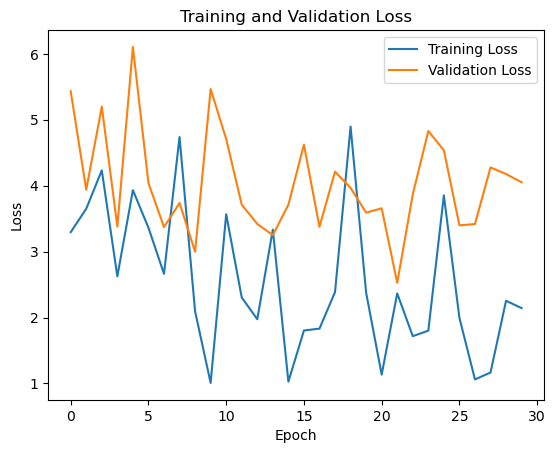

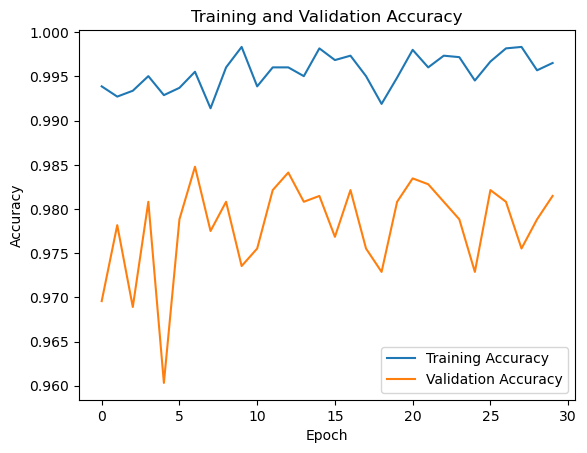

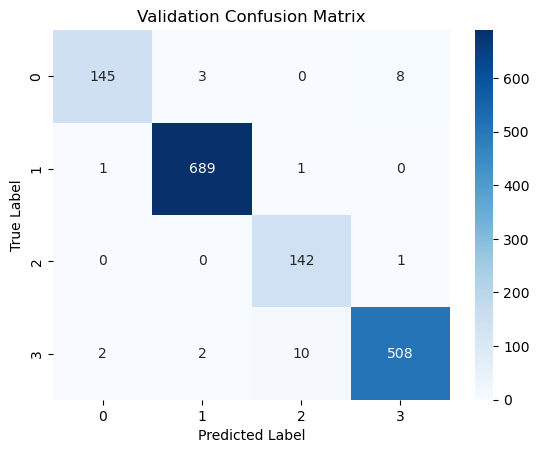

In [54]:
n_epochs = 30

training_loop(
    n_epochs = n_epochs, 
    optimizer = resnet_optimized,
    model = resnet_model, 
    device = device,
    loss_fn = loss_fn,
    train_loader = train_loader,
    val_loader = val_loader
)



The performance of the model is improving with each epoch. The training loss and the validation loss are both decreasing which means that the model is learning to fit the data better. The training and validation accuracy are both increasing which indicates that the model is able to classify the labels correctly. The model is likely to generalie data and perform better than the previous CNN model.
Next, the dataframe for the outputs is retrieved and stored in a csv file.

In [153]:
import pandas as pd

def test_accuracy(net, test_data, device="cpu"):
    testloader = torch.utils.data.DataLoader(test_data, batch_size=4, shuffle=False, num_workers=2)

    correct = 0
    total = 0
    predicted_labels = []
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            predicted_labels.extend(predicted.tolist())

    filenames = test_df['Filename'].tolist()
    results_dict = {'Filename': filenames, 'Label': predicted_labels}
    results_df = pd.DataFrame.from_dict(results_dict)

    accuracy = correct / total
    return accuracy, results_df

In [67]:
best, df3 = test_accuracy(resnet_optimized, test_data, device="cpu")

In [72]:
os.chdir('/kaggle/working/')

In [73]:
df3 = df3.to_csv('output3.csv', index=False)

# CAPTUM

Again, the most important regions are visually represented. 

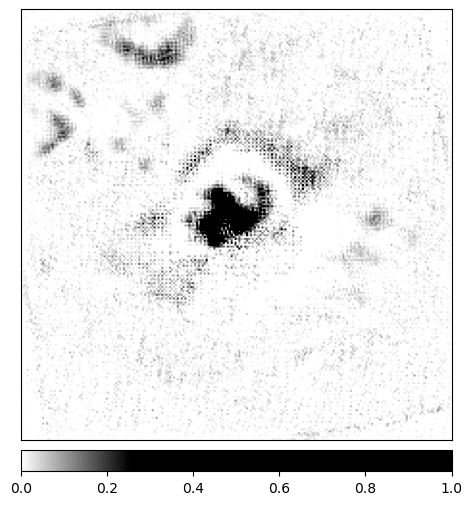

In [44]:
ig = IntegratedGradients(resnet_model)

resnet_model.eval()

image, label = next(iter(val_loader))

attributions, delta = ig.attribute(image.to(device), target=label.to(device), return_convergence_delta=True)

default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)
_ = viz.visualize_image_attr(np.transpose(attributions[0].squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(image[0].squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)